<a href="https://colab.research.google.com/github/zahrapuspita10/Klasifikasi-Hate-Speech/blob/main/Copy_of_Model_5_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498207 sha256=9b597f3e02d829a4fb0e1750dc838383c09a82f011570cf1aaffca5244903dbb
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.4.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 119.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

# EDA

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/', delimiter=';')
data.head()

,stemming,hasil_label_awal
0,tau perintah korea program sterilisasi anjing ...,Non-Hate Speech
1,anjing jawir gombong ketemu stadion gue gebuki...,Hate Speech
2,kontol pejabatpejabat perintah loh anjing biki...,Hate Speech
3,bpjs masuk tuh duo koruptor bpjs pbi gue muak ...,Provokasi
4,perintah usaha anjing ya rakjel sengsara bilan...,Hate Speech


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12280 entries, 0 to 12279
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stemming          12280 non-null  object
 1   hasil_label_awal  12280 non-null  object
dtypes: object(2)
memory usage: 192.0+ KB


In [ ]:
print(data['hasil_label_awal'].value_counts())

hasil_label_awal
Hate Speech        5342
Non-Hate Speech    5216
Provokasi          1722
Name: count, dtype: int64


/tmp/ipython-input-3381281533.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


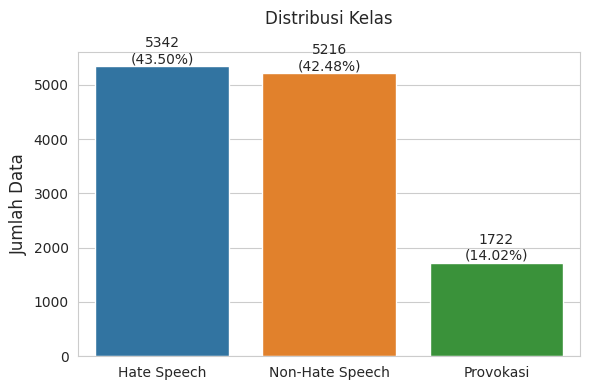


Rasio antara label terbanyak dan tersedikit: 3.10


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

col = 'hasil_label_awal'

# Persentase distribusi label
label_counts = data[col].value_counts()
total = len(data[col])

# Visualisasi distribusi label
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6, 4))

ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette='tab10'
)

# Judul & label sumbu mengikuti contoh
plt.title('Distribusi Kelas', fontsize=12, pad=20)
plt.xlabel('')
plt.ylabel('Jumlah Data', fontsize=12)

# Anotasi jumlah & persentase di atas tiap batang
for i, count in enumerate(label_counts.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

ratio = label_counts.max() / label_counts.min()
print(f"\nRasio antara label terbanyak dan tersedikit: {ratio:.2f}")

# ENCODING

In [ ]:
# Pastikan 'stemming' tidak NaN
data['stemming'] = data['stemming'].fillna('').astype(str)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12280 entries, 0 to 12279
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stemming          12280 non-null  object
 1   hasil_label_awal  12280 non-null  object
dtypes: object(2)
memory usage: 192.0+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_order = ['Non-Hate Speech', 'Hate Speech', 'Provokasi']

# Label Encoder
le = LabelEncoder()
le.classes_ = np.array(label_order)

# Encode label menjadi angka dan tambahkan ke dataframe
data['label_encoded'] = le.transform(data['hasil_label_awal'])

# Hasil
df_encoded = data[['stemming', 'hasil_label_awal', 'label_encoded']].head(10)

print("Mapping label ke angka:", {label: idx for idx, label in enumerate(label_order)})
display(df_encoded)

Mapping label ke angka: {'Non-Hate Speech': 0, 'Hate Speech': 1, 'Provokasi': 2}


,stemming,hasil_label_awal,label_encoded
0,tau perintah korea program sterilisasi anjing ...,Non-Hate Speech,0
1,anjing jawir gombong ketemu stadion gue gebuki...,Hate Speech,1
2,kontol pejabatpejabat perintah loh anjing biki...,Hate Speech,1
3,bpjs masuk tuh duo koruptor bpjs pbi gue muak ...,Provokasi,2
4,perintah usaha anjing ya rakjel sengsara bilan...,Hate Speech,1
5,wkwkw rumah akhirat salat subuh miss suka omon...,Non-Hate Speech,0
6,anjing perintah sial,Hate Speech,1
7,dzalim banget perintah anjing,Hate Speech,1
8,selagi perintah hilang nama parkir liar urus n...,Hate Speech,1
9,anjing got rumah salah perintah,Non-Hate Speech,0


In [ ]:
print("\nJumlah tiap label setelah encoding:")
encoding_counts = data['label_encoded'].value_counts().sort_index()

for idx, count in encoding_counts.items():
    print(f"Label {idx} ({le.classes_[idx]}): {count}")


Jumlah tiap label setelah encoding:
Label 0 (Non-Hate Speech): 5216
Label 1 (Hate Speech): 5342
Label 2 (Provokasi): 1722


# FASTTEXT FIX

In [ ]:
# Simpan ke file txt untuk training FastText
with open("corpus_fasttext.txt", "w", encoding="utf-8") as f:
    for line in data['stemming'].tolist():
        f.write(line + "\n")

In [ ]:
import fasttext

model_ft = fasttext.train_unsupervised(
    "corpus_fasttext.txt",
    model='skipgram',   # bisa diganti 'cbow'
    dim=300,            # dimensi embedding
    ws=5,               # window size
    minn=3,             # minimal character n-gram
    maxn=6,             # maksimal character n-gram
    epoch=30,
    lr=0.03
)

In [ ]:
from tqdm import tqdm

def get_sentence_vector(text):
    words = text.split()
    vectors = [model_ft.get_word_vector(w) for w in words]

    if len(vectors) == 0:
        return np.zeros(model_ft.get_dimension())

    return np.mean(vectors, axis=0)

In [ ]:
X_vectors = np.array([
    get_sentence_vector(text)
    for text in tqdm(data['stemming'], desc="Vectorizing")
])

In [ ]:
df_vectors = pd.DataFrame({
    "text": data['stemming'],
    "vector": [vec for vec in X_vectors]
})

df_vectors.head()

In [ ]:
vec = model_ft.get_word_vector("pemerintah")
print(vec)

In [ ]:
model_ft.get_nearest_neighbors("pemerintah", k=10)

In [ ]:
# Simpan model
model_ft.save_model("fasttext_facebook_5.bin")

# LOAD MODEL FASTTEXT

In [ ]:
model_ft = fasttext.load_model('/content/drive/')

In [ ]:
def get_sentence_vector(text):
    words = text.split()
    vectors = [model_ft.get_word_vector(w) for w in words]
    if not vectors:
        return np.zeros(model_ft.get_dimension())
    return np.mean(vectors, axis=0)

In [ ]:
X_vectors = np.array([
    get_sentence_vector(text)
    for text in tqdm(data['stemming'], desc="Vectorizing")
])

Vectorizing: 100%|██████████| 12280/12280 [00:03<00:00, 3845.58it/s]


In [ ]:
df_vectors = pd.DataFrame({
    "text": data['stemming'],
    "vector": [vec for vec in X_vectors]
})

df_vectors.head()

,text,vector
0,tau perintah korea program sterilisasi anjing ...,"[-0.0054358332, 0.079325, -0.08999485, 0.08005..."
1,anjing jawir gombong ketemu stadion gue gebuki...,"[0.051634572, -0.042664852, -0.18171397, 0.085..."
2,kontol pejabatpejabat perintah loh anjing biki...,"[0.096329555, -0.032967467, -0.14442953, 0.069..."
3,bpjs masuk tuh duo koruptor bpjs pbi gue muak ...,"[0.0014710207, -0.008391094, -0.07687144, 0.09..."
4,perintah usaha anjing ya rakjel sengsara bilan...,"[0.0906602, 0.0038282599, -0.1476996, 0.071795..."


In [ ]:
model_ft.get_nearest_neighbors("pemerintah", k=10)

[(0.9236235022544861, 'pmerintah'),
 (0.842316210269928, 'perintah'),
 (0.6738582849502563, 'ketidakadilan'),
 (0.653097927570343, 'valid'),
 (0.6471743583679199, 'cegah'),
 (0.6452279686927795, 'terhdp'),
 (0.644432544708252, 'organisir'),
 (0.6403565406799316, 'tpnpb'),
 (0.6277775168418884, 'musnah'),
 (0.6211521625518799, 'opm')]

# MODEL 80:20

# SVM

## Fix Model 1 SVM + FastText Scaling Baseline

In [ ]:
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print("Jumlah Data Setelah Train-Test Split Tanpa SMOTE")
print("Total data :", len(X_vectors))
print("Data Train:", len(X_train))
print("Data Test :", len(X_test))

Jumlah Data Setelah Train-Test Split Tanpa SMOTE
Total data : 12280
Data Train: 9824
Data Test : 2456


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# Default SVM
svm_baseline = SVC()
svm_baseline.fit(X_train_scaled, y_train)

SVC()

In [ ]:
# Prediksi
y_pred_base = svm_baseline.predict(X_test_scaled)

In [ ]:
#Evaluasi keseluruhan
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Performa Model Baseline SVM")

accuracy  = accuracy_score(y_test, y_pred_base) * 100
precision = precision_score(y_test, y_pred_base, average='weighted') * 100
recall    = recall_score(y_test, y_pred_base, average='weighted') * 100
f1        = f1_score(y_test, y_pred_base, average='weighted') * 100

print("\nSVM Accuracy Score")
print(accuracy)

print("\nSVM Precision Score")
print(precision)

print("\nSVM Recall Score")
print(recall)

print("\nSVM F1 Score")
print(f1)

Performa Model Baseline SVM

SVM Accuracy Score
85.83061889250814

SVM Precision Score
86.13405241701498

SVM Recall Score
85.83061889250814

SVM F1 Score
85.54600493799455


In [ ]:
# Evaluasi per kelas
print("\nBASELINE SVM")
print("Akurasi:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, target_names=label_order))


BASELINE SVM
Akurasi: 0.8583061889250815
                 precision    recall  f1-score   support

Non-Hate Speech       0.82      0.91      0.87      1043
    Hate Speech       0.89      0.88      0.89      1069
      Provokasi       0.89      0.62      0.73       344

       accuracy                           0.86      2456
      macro avg       0.87      0.80      0.83      2456
   weighted avg       0.86      0.86      0.86      2456



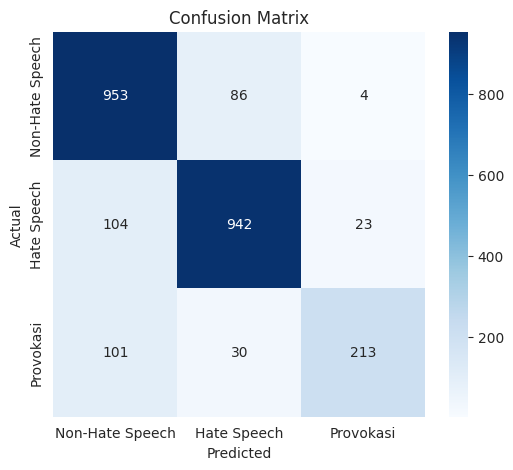

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_order,
    yticklabels=label_order
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Save Model

In [ ]:
import joblib

# Simpan model
joblib.dump(svm_baseline, "svm_fasttext_scaling_baseline.pkl")

# Simpan scaler
joblib.dump(scaler, "scaler_baseline.pkl")

['scaler_baseline.pkl']

## Fix Model 2 SVM + FastText + SMOTE TRAIN + Scaling + Tuning

In [ ]:
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Jumlah Data Setelah Train-Test Split Sebelum SMOTE")
print("Total data :", len(X_vectors))
print("Data Train:", len(X_train))
print("Data Test :", len(X_test))

Jumlah Data Setelah Train-Test Split Sebelum SMOTE
Total data : 12280
Data Train: 9824
Data Test : 2456


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nJumlah Data Setelah SMOTE")
print("Data Train SMOTE:", len(X_train_smote))


Jumlah Data Setelah SMOTE
Data Train SMOTE: 12819


/tmp/ipython-input-733761100.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-733761100.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


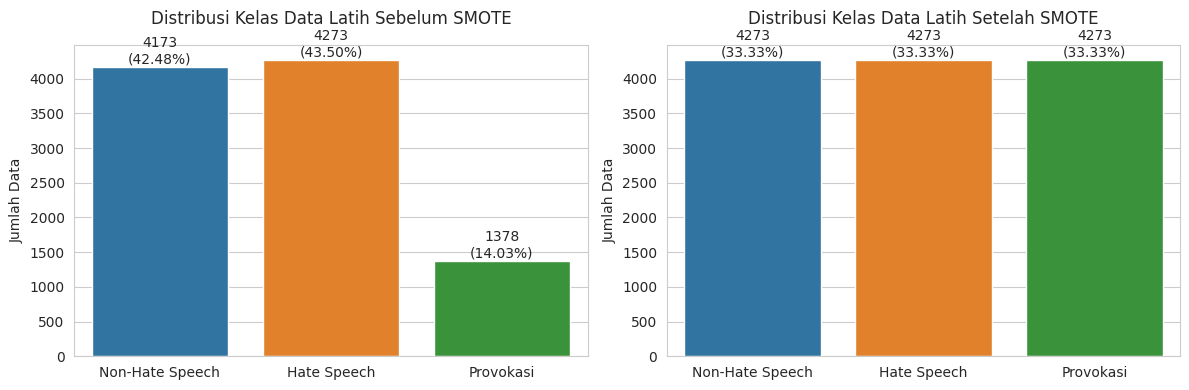

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Data latih sebelum SMOTE
before_counts = pd.Series(y_train).value_counts().sort_index()
before_total = len(y_train)
before_labels = [label_order[i] for i in before_counts.index]

# --- Data latih setelah SMOTE
after_counts = pd.Series(y_train_smote).value_counts().sort_index()
after_total = len(y_train_smote)
after_labels = [label_order[i] for i in after_counts.index]

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Grafik Sebelum SMOTE ---
sns.barplot(
    ax=axes[0],
    x=before_labels,
    y=before_counts.values,
    palette='tab10'
)
axes[0].set_title('Distribusi Kelas Data Latih Sebelum SMOTE', fontsize=12, pad=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Jumlah Data')

for i, count in enumerate(before_counts.values):
    pct = f'{100 * count / before_total:.2f}%'
    axes[0].text(i, count, f'{count}\n({pct})',
                 ha='center', va='bottom', fontsize=10)

# --- Grafik Setelah SMOTE ---
sns.barplot(
    ax=axes[1],
    x=after_labels,
    y=after_counts.values,
    palette='tab10'
)
axes[1].set_title('Distribusi Kelas Data Latih Setelah SMOTE', fontsize=12, pad=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('Jumlah Data')

for i, count in enumerate(after_counts.values):
    pct = f'{100 * count / after_total:.2f}%'
    axes[1].text(i, count, f'{count}\n({pct})',
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline: Scaling -> SMOTE -> SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42))
])

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Ruang pencarian hyperparameter (lengkap & terkontrol)
param_dist = {
    'svm__kernel': ['rbf'],
    'svm__C': np.logspace(-2, 2, 20),
    'svm__gamma': np.logspace(-4, -1, 10),
    'svm__class_weight': [None, 'balanced']
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit hanya pada data latih
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('svm', SVC(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'svm__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1...6913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                                        'svm__class_weight': [None, 'balanced'],
                                        'svm__gamma': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ]),
                                        'svm__kernel': ['rbf']},
                   random_state=42, scoring='f1_macro', verbose=1)

In [ ]:
best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
print("Best CV Score (F1-macro):", random_search.best_score_)

Best Parameters: {'svm__kernel': 'rbf', 'svm__gamma': np.float64(0.004641588833612777), 'svm__class_weight': None, 'svm__C': np.float64(2.06913808111479)}
Best CV Score (F1-macro): 0.8290277153894383


In [ ]:
best_params = random_search.best_params_
print(best_params)

{'svm__kernel': 'rbf', 'svm__gamma': np.float64(0.004641588833612777), 'svm__class_weight': None, 'svm__C': np.float64(2.06913808111479)}


In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(
        C=best_params['svm__C'],
        kernel=best_params['svm__kernel'],
        gamma=best_params['svm__gamma'],
        random_state=42
    ))
])

In [ ]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('svm',
                 SVC(C=np.float64(2.06913808111479),
                     gamma=np.float64(0.004641588833612777),
                     random_state=42))])

In [ ]:
#Evaluasi keseluruhan
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Performa Model Optimasi SVM")

accuracy  = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall    = recall_score(y_test, y_pred, average='weighted') * 100
f1        = f1_score(y_test, y_pred, average='weighted') * 100

print("\nSVM Accuracy Score")
print(accuracy)

print("\nSVM Precision Score")
print(precision)

print("\nSVM Recall Score")
print(recall)

print("\nSVM F1 Score")
print(f1)

Performa Model Optimasi SVM

SVM Accuracy Score
86.2785016286645

SVM Precision Score
86.3138034456331

SVM Recall Score
86.2785016286645

SVM F1 Score
86.22106197042297


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = final_pipeline.predict(X_test)

print("\nOptimasi SVM")
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_order))


Optimasi SVM
Akurasi: 0.862785016286645
                 precision    recall  f1-score   support

Non-Hate Speech       0.84      0.90      0.87      1043
    Hate Speech       0.91      0.87      0.89      1069
      Provokasi       0.79      0.72      0.75       344

       accuracy                           0.86      2456
      macro avg       0.85      0.83      0.84      2456
   weighted avg       0.86      0.86      0.86      2456



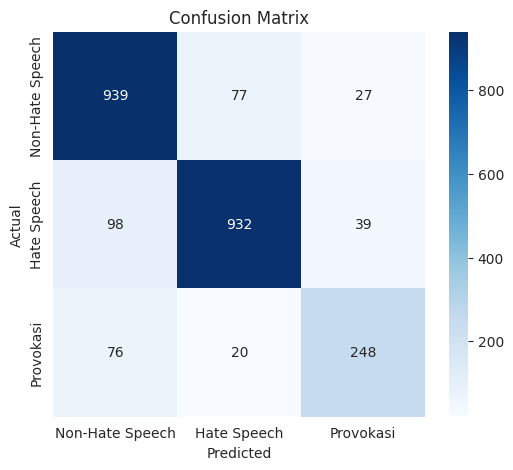

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_opt = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_order,
    yticklabels=label_order
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Save Model SMOTE DATA TRAIN

In [ ]:
import joblib
joblib.dump(final_pipeline, 'svm_optimasi_model_smote_train.pkl')

['svm_optimasi_model_smote_train.pkl']

# LSTM

## Fix Model 1 LSTM + FastText Baseline

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

texts = data['stemming'].astype(str).tolist()
y = data['label_encoded']

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [ ]:
# Convert Text ke Sequences
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(s) for s in sequences)
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post')

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_index.items():
    embedding_matrix[idx] = model_ft.get_word_vector(word)

In [ ]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print("Jumlah Data Sebelum Split")
print("Total sampel :", len(X_seq))
print("Total label  :", len(y))
print(y.value_counts())  # distribusi kelas

print("\nJumlah Data Setelah Split")
print("X_train :", X_train_lstm.shape)
print("X_test  :", X_test_lstm.shape)
print("y_train :", len(y_train_lstm))
print("y_test  :", len(y_test_lstm))

Jumlah Data Sebelum Split
Total sampel : 12280
Total label  : 12280
label_encoded
1    5342
0    5216
2    1722
Name: count, dtype: int64

Jumlah Data Setelah Split
X_train : (9824, 45)
X_test  : (2456, 45)
y_train : 9824
y_test  : 2456


In [ ]:
model_baseline = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),      # baseline: embedding tidak dilatih

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(len(np.unique(y)), activation='softmax')
])

model_baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_baseline.build(input_shape=(None, max_len))
model_baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 45, 300)        │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,154,295 (19.66 MB)

 Trainable params: 97,795 (382.01 KB)

 Non-trainable params: 5,056,500 (19.29 MB)

In [ ]:
history_baseline = model_baseline.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=10,
    batch_size=32
)

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5423 - loss: 0.8993 - val_accuracy: 0.8009 - val_loss: 0.5225
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8280 - loss: 0.4790 - val_accuracy: 0.8705 - val_loss: 0.3687
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8766 - loss: 0.3606 - val_accuracy: 0.8868 - val_loss: 0.3258
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8840 - loss: 0.3336 - val_accuracy: 0.8966 - val_loss: 0.3143
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9097 - loss: 0.2639 - val_accuracy: 0.9084 - val_loss: 0.2352
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9193 - loss: 0.2233 - val_accuracy: 0.9190 - val_loss: 0.2153
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9290 - loss: 0.1988 - val_accuracy: 0.9235 - val_loss: 0.2129
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9389 - loss: 0.1767 - val_accuracy: 

In [ ]:
#Evaluasi keseluruhan
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Performa Model Baseline LSTM")

accuracy  = accuracy_score(y_test_lstm, y_pred_lstm) * 100
precision = precision_score(y_test_lstm, y_pred_lstm, average='weighted') * 100
recall    = recall_score(y_test_lstm, y_pred_lstm, average='weighted') * 100
f1        = f1_score(y_test_lstm, y_pred_lstm, average='weighted') * 100

print("\nLSTM Accuracy Score")
print(accuracy)

print("\nLSTM Precision Score")
print(precision)

print("\nLSTM Recall Score")
print(recall)

print("\nLSTM F1 Score")
print(f1)

Performa Model Baseline LSTM

LSTM Accuracy Score
94.95114006514657

LSTM Precision Score
95.20450008982331

LSTM Recall Score
94.95114006514657

LSTM F1 Score
94.95884020272712


In [ ]:
# Prediksi
y_pred_prob = model_baseline.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

# Evaluasi
print("\nBASELINE LSTM")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred_lstm))
print(classification_report(
    y_test_lstm,
    y_pred_lstm,
    target_names=label_order
))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

BASELINE LSTM
Akurasi: 0.9495114006514658
                 precision    recall  f1-score   support

Non-Hate Speech       0.91      0.99      0.95      1043
    Hate Speech       0.99      0.93      0.96      1069
      Provokasi       0.95      0.90      0.92       344

       accuracy                           0.95      2456
      macro avg       0.95      0.94      0.94      2456
   weighted avg       0.95      0.95      0.95      2456



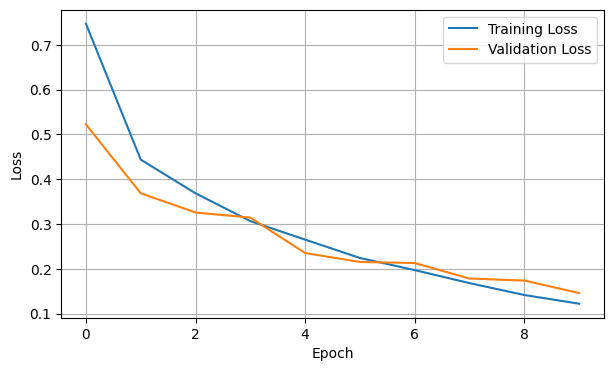

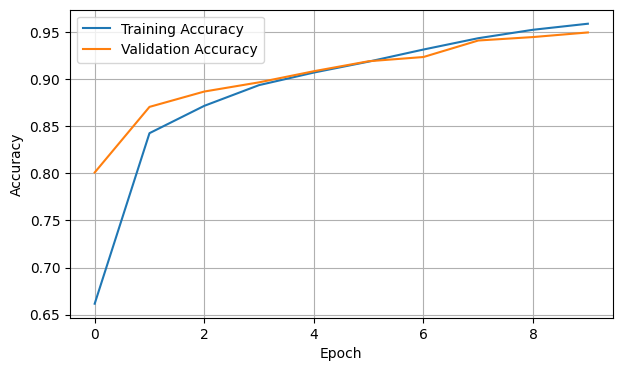

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(7, 4))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

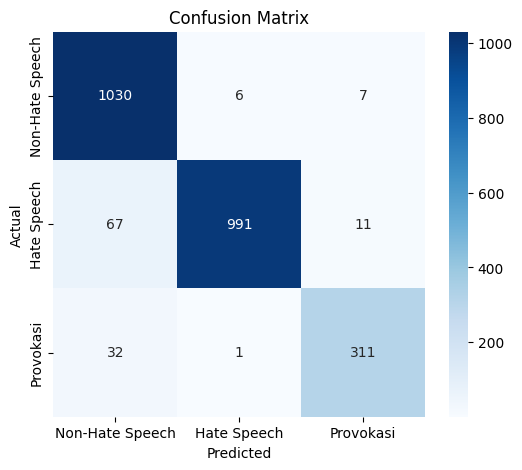

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Hitung Confusion Matrix ---
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_lstm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Save Model

In [ ]:
# Simpan model baseline LSTM + FastText
model_baseline.save("model_baseline_lstm_fasttext.keras")

In [ ]:
import pickle

with open("tokenizer_baseline_lstm.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

## Fix Model 2 LSTM Optimasi

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.4.2


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 25.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Distribusi Label Sebelum SMOTE (Data Latih)")
print(pd.Series(y_train_lstm).value_counts())

Distribusi Label Sebelum SMOTE (Data Latih)
label_encoded
1    4273
0    4173
2    1378
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Flatten sequence
X_train_flat = X_train_lstm.reshape(X_train_lstm.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(
    X_train_flat, y_train_lstm
)

# Kembalikan ke bentuk sequence
X_train_smote = X_train_smote.reshape(
    X_train_smote.shape[0],
    X_train_lstm.shape[1]
)

print("\nDistribusi Label Setelah SMOTE (Data Latih)")
print(pd.Series(y_train_smote).value_counts())


Distribusi Label Setelah SMOTE (Data Latih)
label_encoded
1    4273
0    4273
2    4273
Name: count, dtype: int64


/tmp/ipython-input-1565802698.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1565802698.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


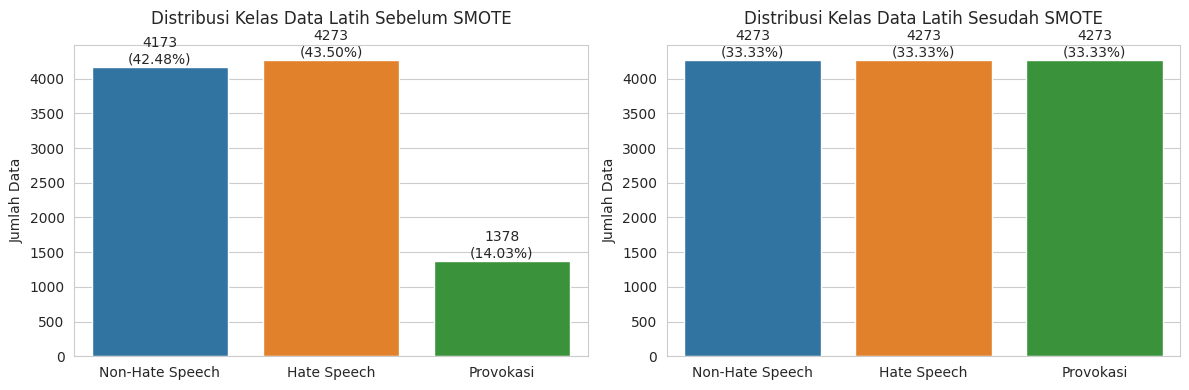

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data latih SEBELUM SMOTE (LSTM)
# ================================
before_counts = pd.Series(y_train_lstm).value_counts().sort_index()
before_total = len(y_train_lstm)
before_labels = [label_order[i] for i in before_counts.index]

# ================================
# Data latih SETELAH SMOTE (LSTM)
# ================================
after_counts = pd.Series(y_train_smote).value_counts().sort_index()
after_total = len(y_train_smote)
after_labels = [label_order[i] for i in after_counts.index]

# ================================
# Plot
# ================================
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# --- Grafik Sebelum SMOTE ---
sns.barplot(
    ax=axes[0],
    x=before_labels,
    y=before_counts.values,
    palette='tab10'
)
axes[0].set_title(
    'Distribusi Kelas Data Latih Sebelum SMOTE',
    fontsize=12,
    pad=15
)
axes[0].set_xlabel('')
axes[0].set_ylabel('Jumlah Data')

for i, count in enumerate(before_counts.values):
    pct = f'{100 * count / before_total:.2f}%'
    axes[0].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

# --- Grafik Setelah SMOTE ---
sns.barplot(
    ax=axes[1],
    x=after_labels,
    y=after_counts.values,
    palette='tab10'
)
axes[1].set_title(
    'Distribusi Kelas Data Latih Sesudah SMOTE',
    fontsize=12,
    pad=15
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Jumlah Data')

for i, count in enumerate(after_counts.values):
    pct = f'{100 * count / after_total:.2f}%'
    axes[1].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

final_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),

    # Best LSTM units
    LSTM(92),
    Dropout(0.4852142919229748),

    Dense(64, activation='relu'),
    Dropout(0.4852142919229748),

    Dense(len(np.unique(y)), activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=0.0022959818254342152),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,056,500 (19.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,056,500 (19.29 MB)

In [ ]:
history = final_model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_test_lstm, y_test_lstm),
    batch_size=64,
    epochs=20,
    verbose=1
)

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.4763 - loss: 1.0018 - val_accuracy: 0.6812 - val_loss: 0.6770
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 237ms/step - accuracy: 0.6876 - loss: 0.7384 - val_accuracy: 0.7948 - val_loss: 0.5537
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.7569 - loss: 0.6327 - val_accuracy: 0.7317 - val_loss: 0.5999
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.7962 - loss: 0.5483 - val_accuracy: 0.8441 - val_loss: 0.4239
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.8209 - loss: 0.4724 - val_accuracy: 0.8339 - val_loss: 0.4102
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.8548 - loss: 0.3919 - val_accuracy: 0.8717 - val_loss: 0.3495
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.8815 - loss: 0.3465 - val_accuracy: 0.8493 - val_loss: 0.4126
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.8865 - loss: 0

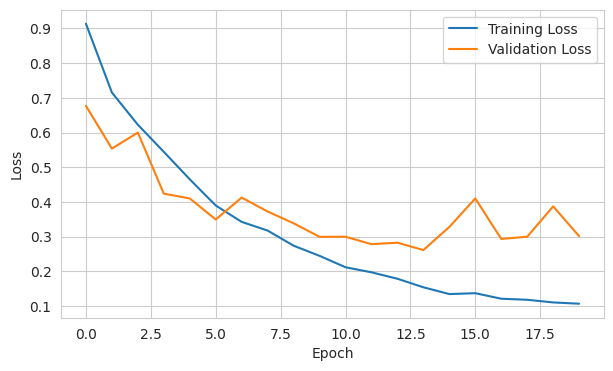

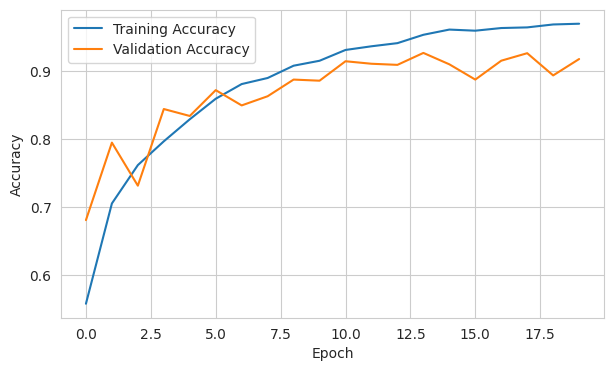

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = final_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nTuning LSTM")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred))
print(classification_report(
    y_test_lstm,
    y_pred,
    target_names=label_order
))

77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step

Tuning LSTM
Akurasi: 0.9173452768729642
                 precision    recall  f1-score   support

Non-Hate Speech       0.95      0.91      0.93      1043
    Hate Speech       0.95      0.94      0.94      1069
      Provokasi       0.75      0.89      0.81       344

       accuracy                           0.92      2456
      macro avg       0.88      0.91      0.89      2456
   weighted avg       0.92      0.92      0.92      2456



In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

print("Performa Model Optimasi LSTM Tuning")

accuracy  = accuracy_score(y_test_lstm, y_pred) * 100
precision = precision_score(y_test_lstm, y_pred, average='weighted') * 100
recall    = recall_score(y_test_lstm, y_pred, average='weighted') * 100
f1        = f1_score(y_test_lstm, y_pred, average='weighted') * 100

print("\nLSTM Accuracy Score")
print(accuracy)

print("\nLSTM Precision Score")
print(precision)

print("\nLSTM Recall Score")
print(recall)

print("\nLSTM F1 Score")
print(f1)

Performa Model Optimasi LSTM Tuning

LSTM Accuracy Score
91.73452768729642

LSTM Precision Score
92.25240973412272

LSTM Recall Score
91.73452768729642

LSTM F1 Score
91.88821856814728


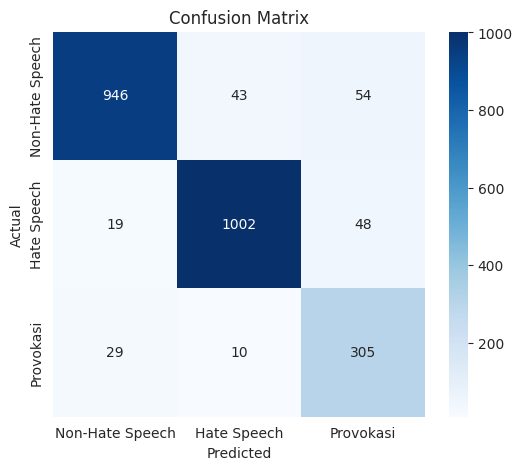

In [ ]:
cm_opt = confusion_matrix(y_test_lstm, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_order,
    yticklabels=label_order
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Fix (2) Model LSTM Optimasi

In [ ]:
from sklearn.model_selection import train_test_split

X_train_final, X_val_lstm, y_train_final, y_val_lstm = train_test_split(
    X_train_smote,
    y_train_smote,
    test_size=0.1,
    random_state=42,
    stratify=y_train_smote
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np

final_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),

    LSTM(
        92,
        dropout=0.2,                 # dropout input ke LSTM
        recurrent_dropout=0.2,       # dropout pada memori internal LSTM
        kernel_regularizer=regularizers.l2(1e-4),   # L2 pada bobot
        recurrent_regularizer=regularizers.l2(1e-4)
    ),

    Dropout(0.4),

    Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),

    Dropout(0.4),

    Dense(len(np.unique(y)), activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=0.0022959818254342152),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,056,500 (19.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,056,500 (19.29 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = final_model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val_lstm, y_val_lstm),
    batch_size=64,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.3787 - loss: 1.1008 - val_accuracy: 0.5328 - val_loss: 0.9644
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.5447 - loss: 0.9636 - val_accuracy: 0.6459 - val_loss: 0.9396
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - accuracy: 0.6340 - loss: 0.8649 - val_accuracy: 0.7098 - val_loss: 0.7090
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.6829 - loss: 0.7734 - val_accuracy: 0.7605 - val_loss: 0.6494
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - accuracy: 0.7321 - loss: 0.7341 - val_accuracy: 0.7793 - val_loss: 0.6256
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.7578 - loss: 0.6743 - val_accuracy: 0.7941 - val_loss: 0.5732
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.7824 - loss: 0.6282 - val_accuracy: 0.8112 - val_loss: 0.5573
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.7905 - loss: 0

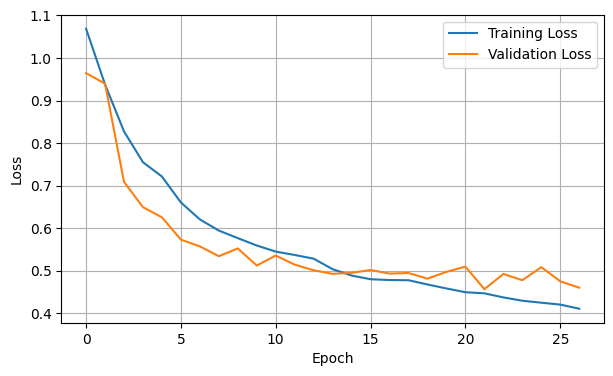

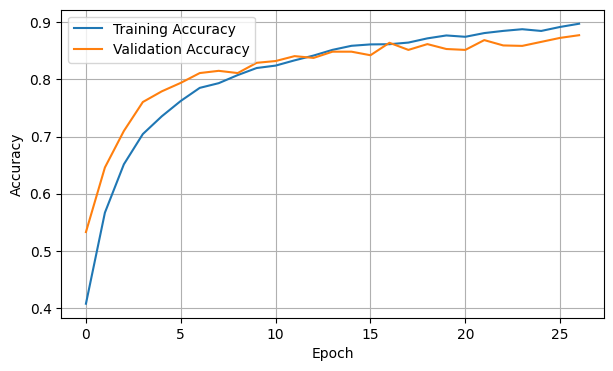

In [ ]:
import matplotlib.pyplot as plt

# Grafik Loss
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Grafik Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

y_pred_prob = final_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nModel LSTM Optimasi (Early Stopping + Regularisasi)")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred))
print(classification_report(
    y_test_lstm,
    y_pred,
    target_names=label_order
))

77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step

Model LSTM Optimasi (Early Stopping + Regularisasi)
Akurasi: 0.9079804560260586
                 precision    recall  f1-score   support

Non-Hate Speech       0.90      0.94      0.92      1043
    Hate Speech       0.98      0.91      0.94      1069
      Provokasi       0.73      0.82      0.77       344

       accuracy                           0.91      2456
      macro avg       0.87      0.89      0.88      2456
   weighted avg       0.91      0.91      0.91      2456



In [ ]:
val_loss, val_acc = final_model.evaluate(X_val_lstm, y_val_lstm)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8546 - loss: 0.4724
Validation loss: 0.4567115902900696
Validation accuracy: 0.8689547777175903


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

print("Performa Model Optimasi LSTM Tuning 2")

accuracy  = accuracy_score(y_test_lstm, y_pred) * 100
precision = precision_score(y_test_lstm, y_pred, average='weighted') * 100
recall    = recall_score(y_test_lstm, y_pred, average='weighted') * 100
f1        = f1_score(y_test_lstm, y_pred, average='weighted') * 100

print("\nLSTM Accuracy Score")
print(accuracy)

print("\nLSTM Precision Score")
print(precision)

print("\nLSTM Recall Score")
print(recall)

print("\nLSTM F1 Score")
print(f1)

Performa Model Optimasi LSTM Tuning 2

LSTM Accuracy Score
90.79804560260585

LSTM Precision Score
91.37120578526188

LSTM Recall Score
90.79804560260585

LSTM F1 Score
90.96618174758916


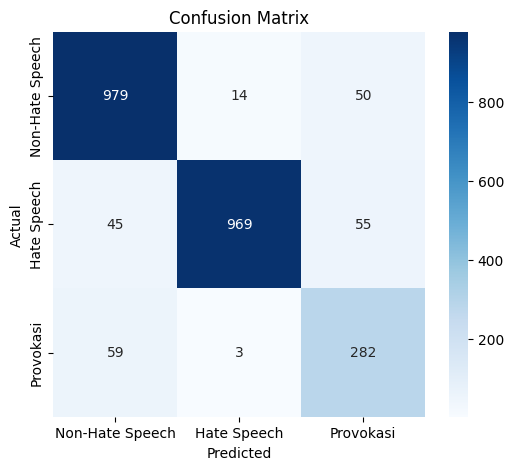

In [ ]:
import seaborn as sns

cm_opt = confusion_matrix(y_test_lstm, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_order,
    yticklabels=label_order
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
final_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 45, 300)        │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 92)             │       144,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         5,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,508,815 (21.01 MB)

 Trainable params: 150,771 (588.95 KB)

 Non-trainable params: 5,056,500 (19.29 MB)

 Optimizer params: 301,544 (1.15 MB)

In [ ]:
final_model.output_shape

(None, 3)

In [ ]:
final_model.save('model_lstm_hatespeech_fix_new.keras')

# LOAD SEMUA MODEL UNTUK GRAFIK

## SVM Baseline

In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
svm_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_fasttext_scaling_baseline.pkl"
)

scaler_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/scaler_baseline.pkl"
)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# Default SVM
svm_baseline = SVC()
svm_baseline.fit(X_train_scaled, y_train)

SVC()

In [ ]:
# Prediksi
y_pred_base = svm_baseline.predict(X_test_scaled)

In [ ]:
# Evaluasi
print("\nBASELINE SVM")
print("Akurasi:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, target_names=label_order))


BASELINE SVM
Akurasi: 0.8583061889250815
                 precision    recall  f1-score   support

Non-Hate Speech       0.82      0.91      0.87      1043
    Hate Speech       0.89      0.88      0.89      1069
      Provokasi       0.89      0.62      0.73       344

       accuracy                           0.86      2456
      macro avg       0.87      0.80      0.83      2456
   weighted avg       0.86      0.86      0.86      2456



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nPerforma Model Baseline SVM")

accuracy  = accuracy_score(y_test, y_pred_base) * 100
precision = precision_score(y_test, y_pred_base, average='weighted') * 100
recall    = recall_score(y_test, y_pred_base, average='weighted') * 100
f1        = f1_score(y_test, y_pred_base, average='weighted') * 100

print("\nSVM Accuracy Score")
print(accuracy)

print("\nSVM Precision Score")
print(precision)

print("\nSVM Recall Score")
print(recall)

print("\nSVM F1 Score")
print(f1)


Performa Model Baseline SVM

SVM Accuracy Score
85.83061889250814

SVM Precision Score
86.13405241701498

SVM Recall Score
85.83061889250814

SVM F1 Score
85.54600493799455


In [ ]:
svm_baseline_f1 = f1_score

## SVM Optimasi

In [ ]:
import joblib

svm_optimasi = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_optimasi_model_smote_train.pkl"
)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid r

In [ ]:
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Jumlah Data Setelah Train-Test Split Sebelum SMOTE")
print("Total data :", len(X_vectors))
print("Data Train:", len(X_train))
print("Data Test :", len(X_test))

Jumlah Data Setelah Train-Test Split Sebelum SMOTE
Total data : 12280
Data Train: 9824
Data Test : 2456


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nJumlah Data Setelah SMOTE")
print("Data Train SMOTE:", len(X_train_smote))


Jumlah Data Setelah SMOTE
Data Train SMOTE: 12819


In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline: Scaling -> SMOTE -> SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42))
])

In [ ]:
import numpy as np
best_params = {'svm__kernel': 'rbf', 'svm__gamma': np.float64(0.004641588833612777), 'svm__class_weight': None, 'svm__C': np.float64(2.06913808111479)}

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(
        C=best_params['svm__C'],
        kernel=best_params['svm__kernel'],
        gamma=best_params['svm__gamma'],
        random_state=42
    ))
])

In [ ]:
from imblearn.pipeline import Pipeline
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('svm',
                 SVC(C=np.float64(2.06913808111479),
                     gamma=np.float64(0.004641588833612777),
                     random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = final_pipeline.predict(X_test)

print("\nOptimasi SVM")
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_order))


Optimasi SVM
Akurasi: 0.862785016286645
                 precision    recall  f1-score   support

Non-Hate Speech       0.84      0.90      0.87      1043
    Hate Speech       0.91      0.87      0.89      1069
      Provokasi       0.79      0.72      0.75       344

       accuracy                           0.86      2456
      macro avg       0.85      0.83      0.84      2456
   weighted avg       0.86      0.86      0.86      2456



In [ ]:
#Evaluasi keseluruhan
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Performa Model Optimasi SVM")

accuracy  = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall    = recall_score(y_test, y_pred, average='weighted') * 100
f1        = f1_score(y_test, y_pred, average='weighted') * 100

print("\nSVM Accuracy Score")
print(accuracy)

print("\nSVM Precision Score")
print(precision)

print("\nSVM Recall Score")
print(recall)

print("\nSVM F1 Score")
print(f1)

Performa Model Optimasi SVM

SVM Accuracy Score
86.2785016286645

SVM Precision Score
86.3138034456331

SVM Recall Score
86.2785016286645

SVM F1 Score
86.22106197042297


In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load model & scaler
svm_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_fasttext_scaling_baseline.pkl"
)

scaler_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/scaler_baseline.pkl"
)

# Split data (HARUS sama seed & proporsi)
X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    data['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=data['label_encoded']
)

# Scaling pakai scaler hasil training
X_test_scaled = scaler_baseline.transform(X_test)

# Prediksi
y_pred_base = svm_baseline.predict(X_test_scaled)

# Evaluasi
accuracy  = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base, average='weighted')
recall    = recall_score(y_test, y_pred_base, average='weighted')
f1        = f1_score(y_test, y_pred_base, average='weighted')

print("Performa Model Baseline SVM")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Performa Model Baseline SVM
Accuracy : 0.8583061889250815
Precision: 0.8613405241701498
Recall   : 0.8583061889250815
F1-score : 0.8554600493799455


In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load pipeline optimasi
svm_optimasi = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_optimasi_model_smote_train.pkl"
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    data['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=data['label_encoded']
)

# Prediksi (pipeline otomatis scaling + SMOTE di TRAIN saja)
y_pred_opt_svm = svm_optimasi.predict(X_test)

# Evaluasi
accuracy  = accuracy_score(y_test, y_pred_opt_svm)
precision = precision_score(y_test, y_pred_opt_svm, average='weighted')
recall    = recall_score(y_test, y_pred_opt_svm, average='weighted')
f1        = f1_score(y_test, y_pred_opt_svm, average='weighted')

print("Performa Model Optimasi SVM")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid r

Performa Model Optimasi SVM
Accuracy : 0.862785016286645
Precision: 0.863138034456331
Recall   : 0.862785016286645
F1-score : 0.8622106197042296


In [ ]:
svm_optimasi_f1 = f1_score

## LSTM Baseline

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/model_baseline_lstm_fasttext.keras"
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 45, 300)        │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,349,887 (20.41 MB)

 Trainable params: 97,795 (382.01 KB)

 Non-trainable params: 5,056,500 (19.29 MB)

 Optimizer params: 195,592 (764.04 KB)

In [ ]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
loss, acc = model.evaluate(X_test_lstm, y_test_lstm)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9445 - loss: 0.1594
Loss: 0.14583948254585266
Accuracy: 0.9495114088058472


In [ ]:
import numpy as np

y_pred_prob = model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(y_test_lstm, y_pred_lstm)
precision = precision_score(y_test_lstm, y_pred_lstm, average='weighted')
recall    = recall_score(y_test_lstm, y_pred_lstm, average='weighted')
f1        = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print("Performa Model LSTM")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

Performa Model LSTM
Accuracy : 0.9495114006514658
Precision: 0.9520450008982332
Recall   : 0.9495114006514658
F1-score : 0.9495884020272711


In [ ]:
lstm_base_f1 = f1

## LSTM Optimasi

In [ ]:
model_lstm_optimasi = load_model(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/model_lstm_fasttext_smote_tuned1_no_early_stop.keras"
)

y_pred_prob_opt = model_lstm_optimasi.predict(X_test_lstm)
y_pred_lstm_opt = np.argmax(y_pred_prob_opt, axis=1)

lstm_optimasi_f1 = f1_score(
    y_test_lstm,
    y_pred_lstm_opt,
    average='weighted'
)

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


In [ ]:
loss, acc = model.evaluate(X_test_lstm, y_test_lstm)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8998 - loss: 0.6682
Loss: 0.5891920328140259
Accuracy: 0.9120520949363708


In [ ]:
import numpy as np

y_pred_prob_opt = model_lstm_optimasi.predict(X_test_lstm)
y_pred_lstm_opt = np.argmax(y_pred_prob_opt, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_opt  = accuracy_score(y_test_lstm, y_pred_lstm_opt)
precision_opt = precision_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
recall_opt    = recall_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
f1_opt        = f1_score(y_test_lstm, y_pred_lstm_opt, average='weighted')

print("Performa LSTM Optimasi")
print("Accuracy :", accuracy_opt)
print("Precision:", precision_opt)
print("Recall   :", recall_opt)
print("F1-score :", f1_opt)

Performa LSTM Optimasi
Accuracy : 0.9120521172638436
Precision: 0.9168935422273022
Recall   : 0.9120521172638436
F1-score : 0.9136651784539558


In [ ]:
lstm_optimasi_f1 = f1_opt

## Grafik

In [ ]:
svm_baseline_f1 = f1_score(
    y_test,
    y_pred_base,
    average='weighted'
)

In [ ]:
svm_optimasi_f1 = f1_score(
    y_test,
    y_pred_opt_svm,
    average='weighted'
)

In [ ]:
print(
    svm_baseline_f1,
    svm_optimasi_f1,
    lstm_base_f1,
    lstm_optimasi_f1
)

0.8554600493799455 0.8622106197042296 0.9495884020272711 0.9136651784539558


In [ ]:
svm_base_acc  = accuracy_score(y_test, y_pred_base)
svm_base_prec = precision_score(y_test, y_pred_base, average='weighted')
svm_base_rec  = recall_score(y_test, y_pred_base, average='weighted')
svm_base_f1   = f1_score(y_test, y_pred_base, average='weighted')

svm_opt_acc  = accuracy_score(y_test, y_pred_opt_svm)
svm_opt_prec = precision_score(y_test, y_pred_opt_svm, average='weighted')
svm_opt_rec  = recall_score(y_test, y_pred_opt_svm, average='weighted')
svm_opt_f1   = f1_score(y_test, y_pred_opt_svm, average='weighted')

lstm_base_acc  = accuracy_score(y_test_lstm, y_pred_lstm)
lstm_base_prec = precision_score(y_test_lstm, y_pred_lstm, average='weighted')
lstm_base_rec  = recall_score(y_test_lstm, y_pred_lstm, average='weighted')
lstm_base_f1   = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

lstm_opt_acc  = accuracy_score(y_test_lstm, y_pred_lstm_opt)
lstm_opt_prec = precision_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
lstm_opt_rec  = recall_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
lstm_opt_f1   = f1_score(y_test_lstm, y_pred_lstm_opt, average='weighted')

In [ ]:
metrics = ['Akurasi', 'Presisi', 'Recall', 'F1-score']

svm_baseline = [
    svm_base_acc * 100,
    svm_base_prec * 100,
    svm_base_rec * 100,
    svm_base_f1 * 100
]

svm_optimasi = [
    svm_opt_acc * 100,
    svm_opt_prec * 100,
    svm_opt_rec * 100,
    svm_opt_f1 * 100
]

lstm_baseline = [
    lstm_base_acc * 100,
    lstm_base_prec * 100,
    lstm_base_rec * 100,
    lstm_base_f1 * 100
]

lstm_optimasi = [
    lstm_opt_acc * 100,
    lstm_opt_prec * 100,
    lstm_opt_rec * 100,
    lstm_opt_f1 * 100
]

In [ ]:
print(svm_baseline)
print(svm_optimasi)
print(lstm_baseline)
print(lstm_optimasi)


[85.83061889250814, np.float64(86.13405241701498), np.float64(85.83061889250814), np.float64(85.54600493799455)]
[86.2785016286645, np.float64(86.3138034456331), np.float64(86.2785016286645), np.float64(86.22106197042297)]
[94.95114006514657, np.float64(95.20450008982331), np.float64(94.95114006514657), np.float64(94.95884020272712)]
[91.20521172638436, np.float64(91.68935422273023), np.float64(91.20521172638436), np.float64(91.36651784539558)]


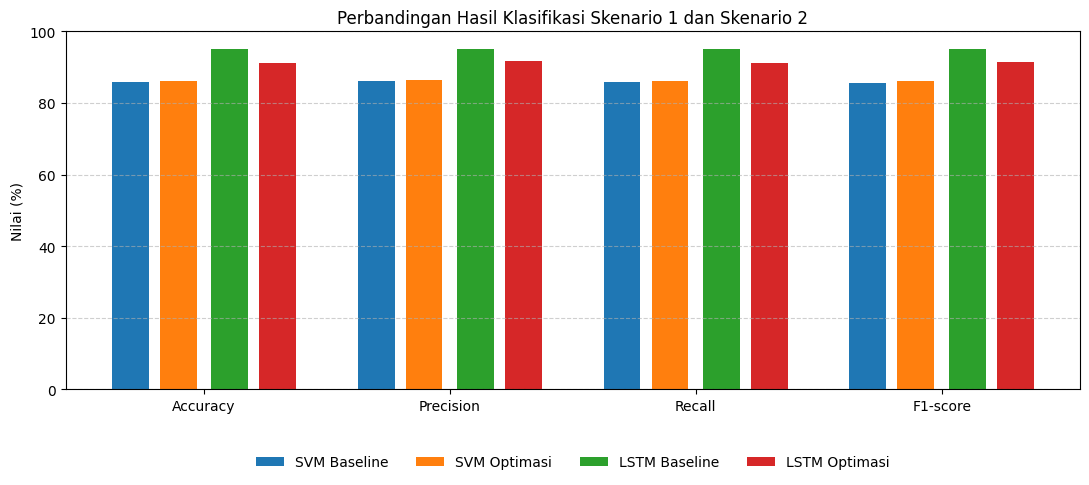

In [ ]:
width = 0.15

plt.figure(figsize=(11,5))

plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline')
plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi')
plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline')
plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi')

plt.xticks(x, metrics)
plt.ylabel('Nilai (%)')
plt.title('Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

plt.tight_layout()
plt.show()

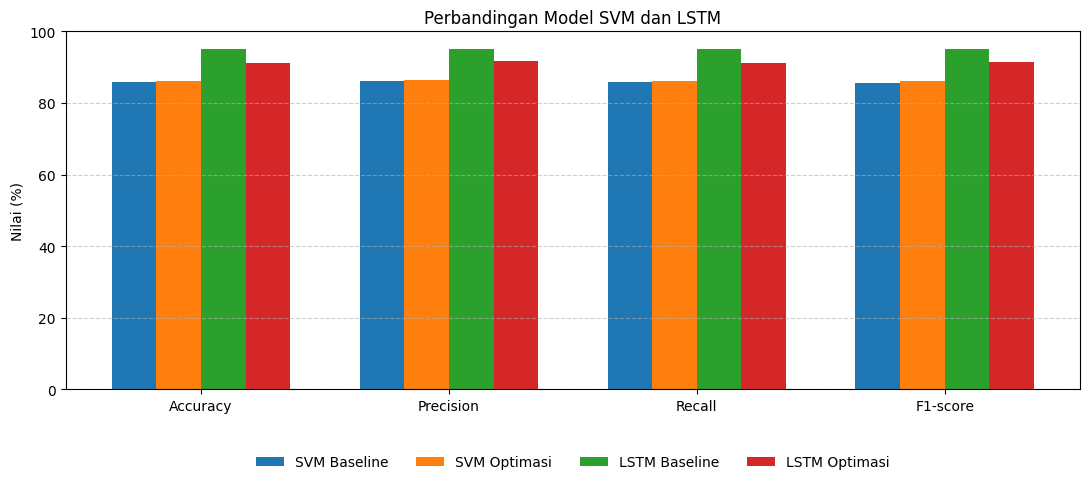

In [ ]:
plt.figure(figsize=(11,5))

plt.bar(x - 1.5*width, svm_baseline, width, label='SVM Baseline')
plt.bar(x - 0.5*width, svm_optimasi, width, label='SVM Optimasi')
plt.bar(x + 0.5*width, lstm_baseline, width, label='LSTM Baseline')
plt.bar(x + 1.5*width, lstm_optimasi, width, label='LSTM Optimasi')

plt.xticks(x, metrics)
plt.ylabel('Nilai (%)')
plt.title('Perbandingan Model SVM dan LSTM')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# INI YANG ANDA MAKSUD
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

plt.tight_layout()
plt.show()

# LOAD SEMUA MODEL VERSI TERBARU

## 2 SVM Baseline

In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
svm_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_fasttext_scaling_baseline.pkl"
)

scaler_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/scaler_baseline.pkl"
)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# Default SVM
svm_baseline = SVC()
svm_baseline.fit(X_train_scaled, y_train)

SVC()

In [ ]:
# Prediksi
y_pred_base = svm_baseline.predict(X_test_scaled)

In [ ]:
# Evaluasi
print("\nBASELINE SVM")
print("Akurasi:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, target_names=label_order))


BASELINE SVM
Akurasi: 0.8583061889250815
                 precision    recall  f1-score   support

Non-Hate Speech       0.82      0.91      0.87      1043
    Hate Speech       0.89      0.88      0.89      1069
      Provokasi       0.89      0.62      0.73       344

       accuracy                           0.86      2456
      macro avg       0.87      0.80      0.83      2456
   weighted avg       0.86      0.86      0.86      2456



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nPerforma Model Baseline SVM")

accuracy  = accuracy_score(y_test, y_pred_base) * 100
precision = precision_score(y_test, y_pred_base, average='weighted') * 100
recall    = recall_score(y_test, y_pred_base, average='weighted') * 100
f1        = f1_score(y_test, y_pred_base, average='weighted') * 100

print("\nSVM Accuracy Score")
print(accuracy)

print("\nSVM Precision Score")
print(precision)

print("\nSVM Recall Score")
print(recall)

print("\nSVM F1 Score")
print(f1)


Performa Model Baseline SVM

SVM Accuracy Score
85.83061889250814

SVM Precision Score
86.13405241701498

SVM Recall Score
85.83061889250814

SVM F1 Score
85.54600493799455


In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load model & scaler
svm_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_fasttext_scaling_baseline.pkl"
)

scaler_baseline = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/scaler_baseline.pkl"
)

# Split data (HARUS sama seed & proporsi)
X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    data['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=data['label_encoded']
)

# Scaling pakai scaler hasil training
X_test_scaled = scaler_baseline.transform(X_test)

# Prediksi
y_pred_base = svm_baseline.predict(X_test_scaled)

# Evaluasi
accuracy  = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base, average='weighted')
recall    = recall_score(y_test, y_pred_base, average='weighted')
f1        = f1_score(y_test, y_pred_base, average='weighted')

print("Performa Model Baseline SVM")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Performa Model Baseline SVM
Accuracy : 0.8583061889250815
Precision: 0.8613405241701498
Recall   : 0.8583061889250815
F1-score : 0.8554600493799455


In [ ]:
svm_baseline_f1 = f1_score

## 2 SVM Optimasi

In [ ]:
import joblib

svm_optimasi = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_optimasi_model_smote_train.pkl"
)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid r

In [ ]:
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Jumlah Data Setelah Train-Test Split Sebelum SMOTE")
print("Total data :", len(X_vectors))
print("Data Train:", len(X_train))
print("Data Test :", len(X_test))

Jumlah Data Setelah Train-Test Split Sebelum SMOTE
Total data : 12280
Data Train: 9824
Data Test : 2456


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nJumlah Data Setelah SMOTE")
print("Data Train SMOTE:", len(X_train_smote))


Jumlah Data Setelah SMOTE
Data Train SMOTE: 12819


In [ ]:
import numpy as np
best_params = {'svm__kernel': 'rbf', 'svm__gamma': np.float64(0.004641588833612777), 'svm__class_weight': None, 'svm__C': np.float64(2.06913808111479)}

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(
        C=best_params['svm__C'],
        kernel=best_params['svm__kernel'],
        gamma=best_params['svm__gamma'],
        random_state=42
    ))
])

In [ ]:
from imblearn.pipeline import Pipeline
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('svm',
                 SVC(C=np.float64(2.06913808111479),
                     gamma=np.float64(0.004641588833612777),
                     random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = final_pipeline.predict(X_test)

print("\nOptimasi SVM")
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_order))


Optimasi SVM
Akurasi: 0.862785016286645
                 precision    recall  f1-score   support

Non-Hate Speech       0.84      0.90      0.87      1043
    Hate Speech       0.91      0.87      0.89      1069
      Provokasi       0.79      0.72      0.75       344

       accuracy                           0.86      2456
      macro avg       0.85      0.83      0.84      2456
   weighted avg       0.86      0.86      0.86      2456



In [ ]:
#Evaluasi keseluruhan
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Performa Model Optimasi SVM")

accuracy  = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall    = recall_score(y_test, y_pred, average='weighted') * 100
f1        = f1_score(y_test, y_pred, average='weighted') * 100

print("\nSVM Accuracy Score")
print(accuracy)

print("\nSVM Precision Score")
print(precision)

print("\nSVM Recall Score")
print(recall)

print("\nSVM F1 Score")
print(f1)

Performa Model Optimasi SVM

SVM Accuracy Score
86.2785016286645

SVM Precision Score
86.3138034456331

SVM Recall Score
86.2785016286645

SVM F1 Score
86.22106197042297


In [ ]:
svm_optimasi_f1 = f1_score

In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load pipeline optimasi
svm_optimasi = joblib.load(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/svm_optimasi_model_smote_train.pkl"
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_vectors,
    data['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=data['label_encoded']
)

# Prediksi (pipeline otomatis scaling + SMOTE di TRAIN saja)
y_pred_opt_svm = svm_optimasi.predict(X_test)

# Evaluasi
accuracy  = accuracy_score(y_test, y_pred_opt_svm)
precision = precision_score(y_test, y_pred_opt_svm, average='weighted')
recall    = recall_score(y_test, y_pred_opt_svm, average='weighted')
f1        = f1_score(y_test, y_pred_opt_svm, average='weighted')

print("Performa Model Optimasi SVM")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid r

Performa Model Optimasi SVM
Accuracy : 0.862785016286645
Precision: 0.863138034456331
Recall   : 0.862785016286645
F1-score : 0.8622106197042296


## 2 LSTM Baseline

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/model_baseline_lstm_fasttext.keras"
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 45, 300)        │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,349,887 (20.41 MB)

 Trainable params: 97,795 (382.01 KB)

 Non-trainable params: 5,056,500 (19.29 MB)

 Optimizer params: 195,592 (764.04 KB)

In [ ]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
loss, acc = model.evaluate(X_test_lstm, y_test_lstm)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9445 - loss: 0.1594
Loss: 0.14583948254585266
Accuracy: 0.9495114088058472


In [ ]:
import numpy as np

y_pred_prob = model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(y_test_lstm, y_pred_lstm)
precision = precision_score(y_test_lstm, y_pred_lstm, average='weighted')
recall    = recall_score(y_test_lstm, y_pred_lstm, average='weighted')
f1        = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print("Performa Model LSTM")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

Performa Model LSTM
Accuracy : 0.9495114006514658
Precision: 0.9520450008982332
Recall   : 0.9495114006514658
F1-score : 0.9495884020272711


In [ ]:
lstm_base_f1 = f1

## 2 LSTM Optimasi New

In [ ]:
model_lstm_optimasi = load_model(
    "/content/drive/MyDrive/MODELLING SKRIPSI/Master/MODEL FIXED BANGET/model_lstm_fasttext_smote_tuned1_no_early_stop.keras"
)

y_pred_prob_opt = model_lstm_optimasi.predict(X_test_lstm)
y_pred_lstm_opt = np.argmax(y_pred_prob_opt, axis=1)

lstm_optimasi_f1 = f1_score(
    y_test_lstm,
    y_pred_lstm_opt,
    average='weighted'
)

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


In [ ]:
val_loss, val_acc = final_model.evaluate(X_val_lstm, y_val_lstm)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8546 - loss: 0.4724
Validation loss: 0.4567115902900696
Validation accuracy: 0.8689547777175903


In [ ]:
import numpy as np

y_pred_prob_opt = model_lstm_optimasi.predict(X_test_lstm)
y_pred_lstm_opt = np.argmax(y_pred_prob_opt, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_opt  = accuracy_score(y_test_lstm, y_pred_lstm_opt)
precision_opt = precision_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
recall_opt    = recall_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
f1_opt        = f1_score(y_test_lstm, y_pred_lstm_opt, average='weighted')

print("Performa LSTM Optimasi")
print("Accuracy :", accuracy_opt)
print("Precision:", precision_opt)
print("Recall   :", recall_opt)
print("F1-score :", f1_opt)

Performa LSTM Optimasi
Accuracy : 0.9120521172638436
Precision: 0.9168935422273022
Recall   : 0.9120521172638436
F1-score : 0.9136651784539558


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_opt  = accuracy_score(y_test_lstm, y_pred_lstm_opt)
precision_opt = precision_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
recall_opt    = recall_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
f1_opt        = f1_score(y_test_lstm, y_pred_lstm_opt, average='weighted')

print("Performa LSTM Optimasi")
print("Accuracy :", accuracy_opt)
print("Precision:", precision_opt)
print("Recall   :", recall_opt)
print("F1-score :", f1_opt)

Performa LSTM Optimasi
Accuracy : 0.9120521172638436
Precision: 0.9168935422273022
Recall   : 0.9120521172638436
F1-score : 0.9136651784539558


In [ ]:
lstm_optimasi_f1 = f1_opt

## Grafik 2

In [ ]:
svm_baseline_f1 = f1_score(
    y_test,
    y_pred_base,
    average='weighted'
)

In [ ]:
svm_optimasi_f1 = f1_score(
    y_test,
    y_pred_opt_svm,
    average='weighted'
)

In [ ]:
print(
    svm_baseline_f1,
    svm_optimasi_f1,
    lstm_base_f1,
    lstm_optimasi_f1
)

0.8554600493799455 0.8622106197042296 0.9495884020272711 0.9136651784539558


In [ ]:
svm_base_acc  = accuracy_score(y_test, y_pred_base)
svm_base_prec = precision_score(y_test, y_pred_base, average='weighted')
svm_base_rec  = recall_score(y_test, y_pred_base, average='weighted')
svm_base_f1   = f1_score(y_test, y_pred_base, average='weighted')

svm_opt_acc  = accuracy_score(y_test, y_pred_opt_svm)
svm_opt_prec = precision_score(y_test, y_pred_opt_svm, average='weighted')
svm_opt_rec  = recall_score(y_test, y_pred_opt_svm, average='weighted')
svm_opt_f1   = f1_score(y_test, y_pred_opt_svm, average='weighted')

lstm_base_acc  = accuracy_score(y_test_lstm, y_pred_lstm)
lstm_base_prec = precision_score(y_test_lstm, y_pred_lstm, average='weighted')
lstm_base_rec  = recall_score(y_test_lstm, y_pred_lstm, average='weighted')
lstm_base_f1   = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

lstm_opt_acc  = accuracy_score(y_test_lstm, y_pred_lstm_opt)
lstm_opt_prec = precision_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
lstm_opt_rec  = recall_score(y_test_lstm, y_pred_lstm_opt, average='weighted')
lstm_opt_f1   = f1_score(y_test_lstm, y_pred_lstm_opt, average='weighted')

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

svm_baseline = [
    svm_base_acc * 100,
    svm_base_prec * 100,
    svm_base_rec * 100,
    svm_base_f1 * 100
]

svm_optimasi = [
    svm_opt_acc * 100,
    svm_opt_prec * 100,
    svm_opt_rec * 100,
    svm_opt_f1 * 100
]

lstm_baseline = [
    lstm_base_acc * 100,
    lstm_base_prec * 100,
    lstm_base_rec * 100,
    lstm_base_f1 * 100
]

lstm_optimasi = [
    lstm_opt_acc * 100,
    lstm_opt_prec * 100,
    lstm_opt_rec * 100,
    lstm_opt_f1 * 100
]

In [ ]:
print(svm_baseline)
print(svm_optimasi)
print(lstm_baseline)
print(lstm_optimasi)

[85.83061889250814, np.float64(86.13405241701498), np.float64(85.83061889250814), np.float64(85.54600493799455)]
[86.2785016286645, np.float64(86.3138034456331), np.float64(86.2785016286645), np.float64(86.22106197042297)]
[94.95114006514657, np.float64(95.20450008982331), np.float64(94.95114006514657), np.float64(94.95884020272712)]
[91.20521172638436, np.float64(91.68935422273023), np.float64(91.20521172638436), np.float64(91.36651784539558)]


In [ ]:
!pip install mplcursors

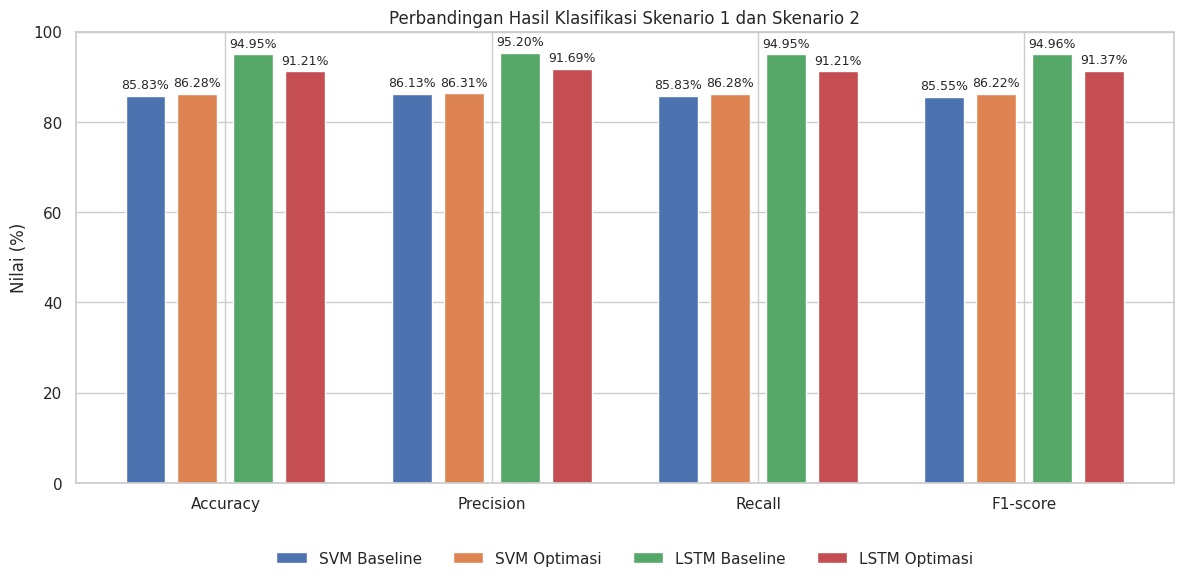

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors

# contoh asumsi variabel Anda sudah ada:
# metrics, svm_baseline, svm_optimasi, lstm_baseline, lstm_optimasi

sns.set(style="whitegrid")

width = 0.15
x = np.arange(len(metrics))

plt.figure(figsize=(12,6))

bars1 = plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline')
bars2 = plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi')
bars3 = plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline')
bars4 = plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi')

plt.xticks(x, metrics)
plt.ylabel("Nilai (%)")
plt.title("Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2")
plt.ylim(0, 100)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

# ------- LABEL PERSENTASE DI ATAS BAR --------
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

# ------- INTERAKTIF TOOLTIP HOVER ----------
cursor = mplcursors.cursor(hover=True)

@cursor.connect("add")
def on_add(sel):
    bar = sel.artist[sel.index]
    sel.annotation.set_text(f"{bar.get_height():.2f}%")
    sel.annotation.get_bbox_patch().set(alpha=0.9)

plt.tight_layout()
plt.show()

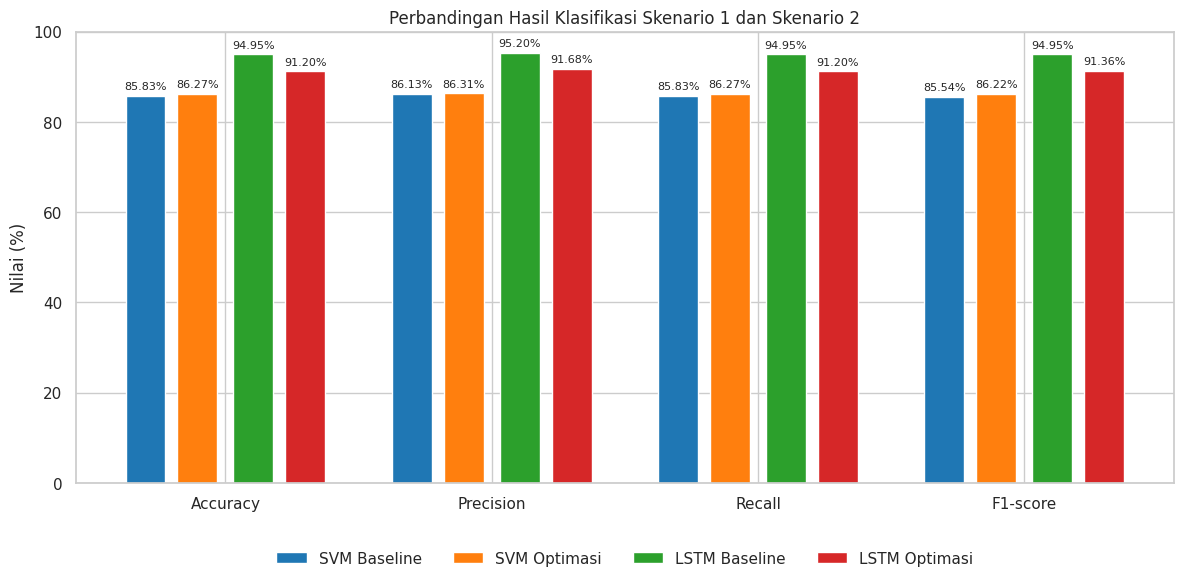

In [ ]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# buat palet warna tab10
palette = sns.color_palette("tab10")

# misalnya kita ambil 4 warna pertama
c1, c2, c3, c4 = palette[:4]

width = 0.15
x = np.arange(len(metrics))

plt.figure(figsize=(12,6))

bars1 = plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline', color=c1)
bars2 = plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi', color=c2)
bars3 = plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline', color=c3)
bars4 = plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi', color=c4)

plt.xticks(x, metrics)
plt.ylabel("Nilai (%)")
plt.title("Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2")
plt.ylim(0, 100)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

# label angka di atas bar (truncate 2 desimal)
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        h = bar.get_height()
        # kalikan 100, floor, lalu bagi 100 → truncate 2 desimal
        truncated = math.floor(h * 100) / 100
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h + 1,
            f"{truncated:.2f}%",
            ha="center",
            va="bottom",
            fontsize=8
        )

plt.tight_layout()
plt.show()

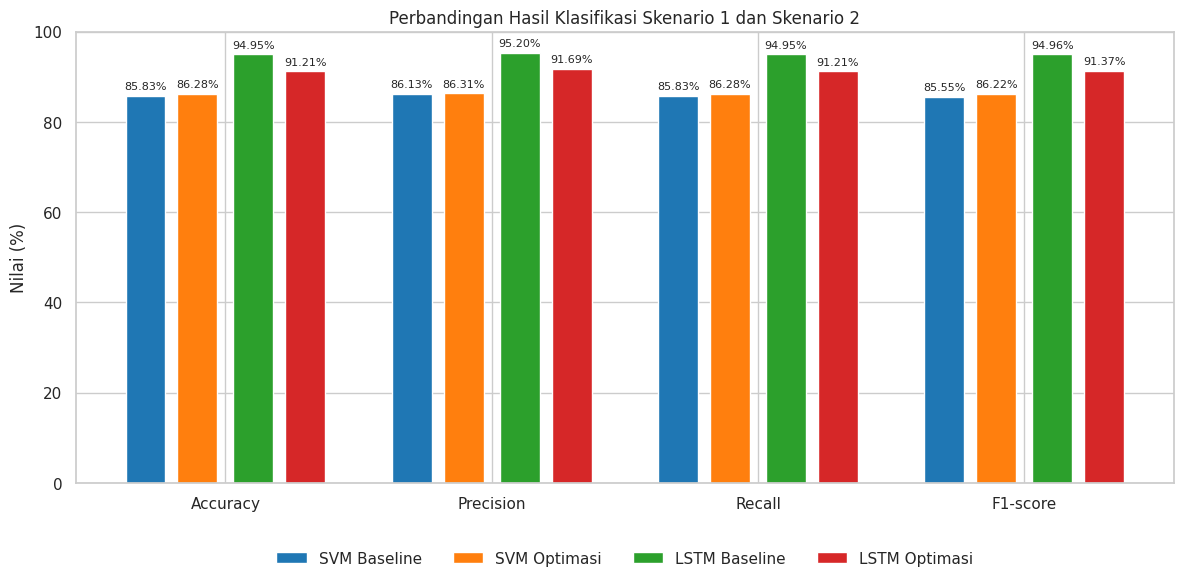

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# buat palet warna tab10
palette = sns.color_palette("tab10")

# misalnya kita ambil 4 warna pertama
c1, c2, c3, c4 = palette[:4]

width = 0.15
x = np.arange(len(metrics))

plt.figure(figsize=(12,6))

bars1 = plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline', color=c1)
bars2 = plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi', color=c2)
bars3 = plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline', color=c3)
bars4 = plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi', color=c4)

plt.xticks(x, metrics)
plt.ylabel("Nilai (%)")
plt.title("Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2")
plt.ylim(0, 100)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

# label angka di atas bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h + 1,
            f"{h:.2f}%",
            ha="center",
            va="bottom",
            fontsize=8
        )

plt.tight_layout()
plt.show()

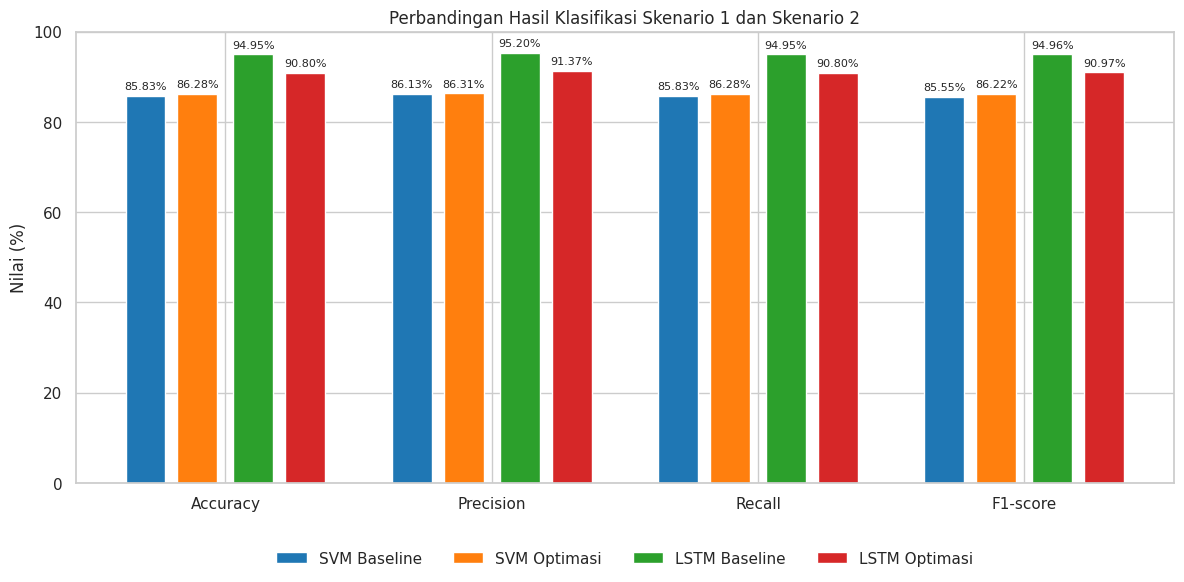

In [ ]:
import seaborn as sns

# buat palet warna tab10
palette = sns.color_palette("tab10")

# misalnya kita ambil 4 warna pertama
c1, c2, c3, c4 = palette[:4]

width = 0.15
x = np.arange(len(metrics))

plt.figure(figsize=(12,6))

bars1 = plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline', color=c1)
bars2 = plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi', color=c2)
bars3 = plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline', color=c3)
bars4 = plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi', color=c4)

plt.xticks(x, metrics)
plt.ylabel("Nilai (%)")
plt.title("Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2")
plt.ylim(0, 100)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

# label angka di atas bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h + 1,
            f"{h:.2f}%",
            ha="center",
            va="bottom",
            fontsize=8
        )

plt.tight_layout()
plt.show()

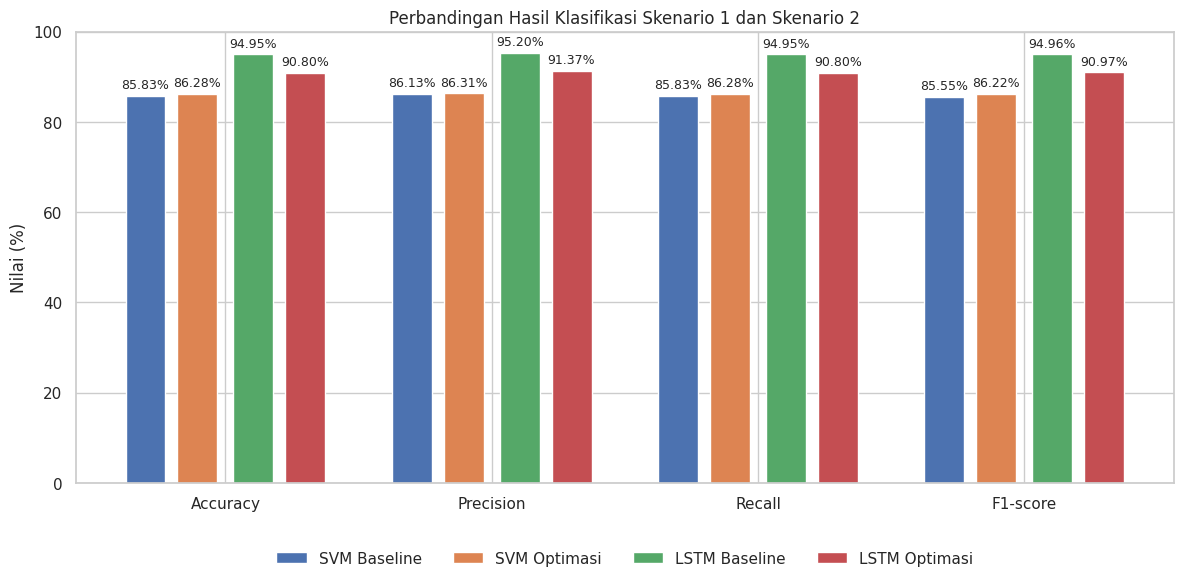

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors

# contoh asumsi variabel Anda sudah ada:
# metrics, svm_baseline, svm_optimasi, lstm_baseline, lstm_optimasi

sns.set(style="whitegrid")

width = 0.15
x = np.arange(len(metrics))

plt.figure(figsize=(12,6))

bars1 = plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline')
bars2 = plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi')
bars3 = plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline')
bars4 = plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi')

plt.xticks(x, metrics)
plt.ylabel("Nilai (%)")
plt.title("Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2")
plt.ylim(0, 100)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

# ------- LABEL PERSENTASE DI ATAS BAR --------
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

# ------- INTERAKTIF TOOLTIP HOVER ----------
cursor = mplcursors.cursor(hover=True)

@cursor.connect("add")
def on_add(sel):
    bar = sel.artist[sel.index]
    sel.annotation.set_text(f"{bar.get_height():.2f}%")
    sel.annotation.get_bbox_patch().set(alpha=0.9)

plt.tight_layout()
plt.show()

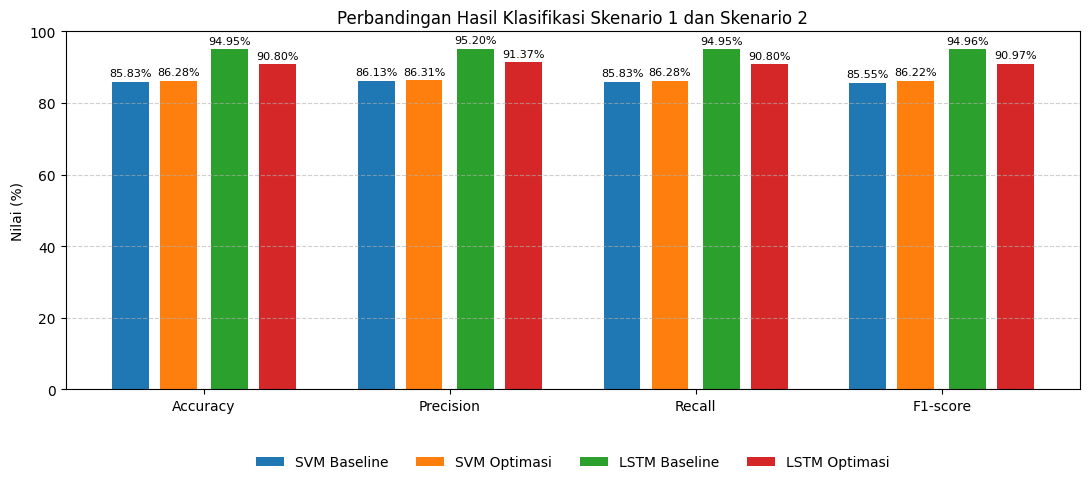

In [ ]:
width = 0.15
x = np.arange(len(metrics)) # Define x here

plt.figure(figsize=(11,5))

bars1 = plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline')
bars2 = plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi')
bars3 = plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline')
bars4 = plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi')

plt.xticks(x, metrics)
plt.ylabel('Nilai (%)')
plt.title('Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

# --- Tambahkan caption persentase di atas batang ---
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f'{height:.2f}%',
            ha='center',
            va='bottom',
            fontsize=8
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.show()

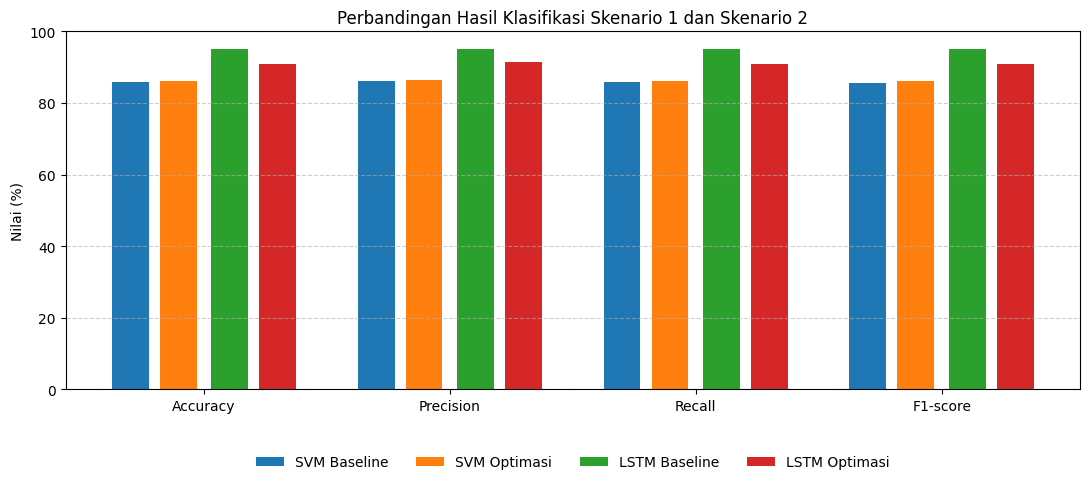

In [ ]:
width = 0.15
x = np.arange(len(metrics)) # Define x here

plt.figure(figsize=(11,5))

plt.bar(x - 2*width, svm_baseline, width, label='SVM Baseline')
plt.bar(x - 0.7*width, svm_optimasi, width, label='SVM Optimasi')
plt.bar(x + 0.7*width, lstm_baseline, width, label='LSTM Baseline')
plt.bar(x + 2*width, lstm_optimasi, width, label='LSTM Optimasi')

plt.xticks(x, metrics)
plt.ylabel('Nilai (%)')
plt.title('Perbandingan Hasil Klasifikasi Skenario 1 dan Skenario 2')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

plt.tight_layout()
plt.show()

# Model 2 LSTM + FastText + SMOTE + Tuning + Percobaan

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Distribusi Label Sebelum SMOTE (Data Latih)")
print(pd.Series(y_train_lstm).value_counts())

Distribusi Label Sebelum SMOTE (Data Latih)
label_encoded
1    4273
0    4173
2    1378
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Flatten sequence
X_train_flat = X_train_lstm.reshape(X_train_lstm.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(
    X_train_flat, y_train_lstm
)

# Kembalikan ke bentuk sequence
X_train_smote = X_train_smote.reshape(
    X_train_smote.shape[0],
    X_train_lstm.shape[1]
)

print("\nDistribusi Label Setelah SMOTE (Data Latih)")
print(pd.Series(y_train_smote).value_counts())


Distribusi Label Setelah SMOTE (Data Latih)
label_encoded
1    4273
0    4273
2    4273
Name: count, dtype: int64


/tmp/ipython-input-1565802698.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1565802698.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


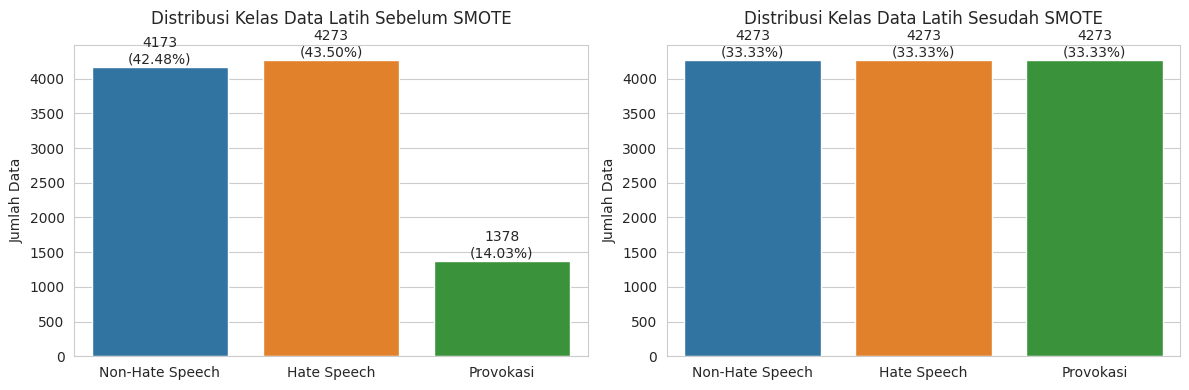

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data latih SEBELUM SMOTE (LSTM)
# ================================
before_counts = pd.Series(y_train_lstm).value_counts().sort_index()
before_total = len(y_train_lstm)
before_labels = [label_order[i] for i in before_counts.index]

# ================================
# Data latih SETELAH SMOTE (LSTM)
# ================================
after_counts = pd.Series(y_train_smote).value_counts().sort_index()
after_total = len(y_train_smote)
after_labels = [label_order[i] for i in after_counts.index]

# ================================
# Plot
# ================================
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# --- Grafik Sebelum SMOTE ---
sns.barplot(
    ax=axes[0],
    x=before_labels,
    y=before_counts.values,
    palette='tab10'
)
axes[0].set_title(
    'Distribusi Kelas Data Latih Sebelum SMOTE',
    fontsize=12,
    pad=15
)
axes[0].set_xlabel('')
axes[0].set_ylabel('Jumlah Data')

for i, count in enumerate(before_counts.values):
    pct = f'{100 * count / before_total:.2f}%'
    axes[0].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

# --- Grafik Setelah SMOTE ---
sns.barplot(
    ax=axes[1],
    x=after_labels,
    y=after_counts.values,
    palette='tab10'
)
axes[1].set_title(
    'Distribusi Kelas Data Latih Sesudah SMOTE',
    fontsize=12,
    pad=15
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Jumlah Data')

for i, count in enumerate(after_counts.values):
    pct = f'{100 * count / after_total:.2f}%'
    axes[1].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

/tmp/ipython-input-1032231940.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1032231940.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


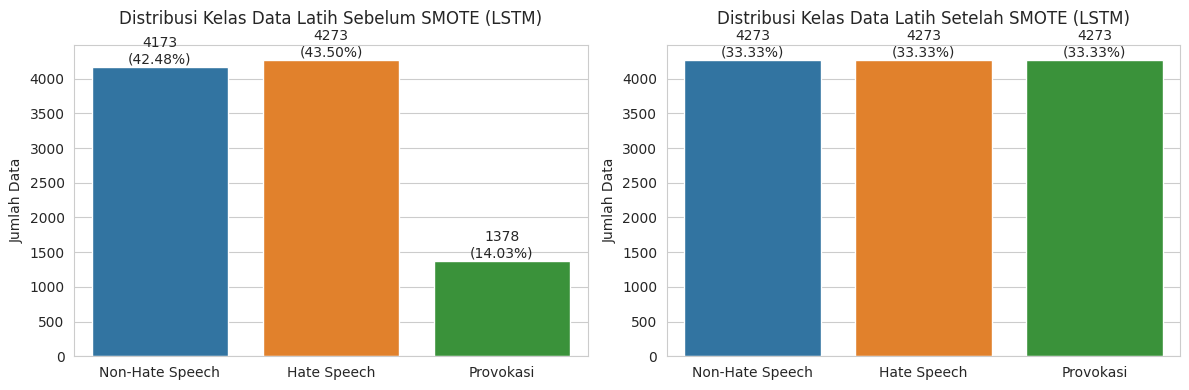

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data latih SEBELUM SMOTE (LSTM)
# ================================
before_counts = pd.Series(y_train_lstm).value_counts().sort_index()
before_total = len(y_train_lstm)
before_labels = [label_order[i] for i in before_counts.index]

# ================================
# Data latih SETELAH SMOTE (LSTM)
# ================================
after_counts = pd.Series(y_train_smote).value_counts().sort_index()
after_total = len(y_train_smote)
after_labels = [label_order[i] for i in after_counts.index]

# ================================
# Plot
# ================================
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# --- Grafik Sebelum SMOTE ---
sns.barplot(
    ax=axes[0],
    x=before_labels,
    y=before_counts.values,
    palette='tab10'
)
axes[0].set_title(
    'Distribusi Kelas Data Latih Sebelum SMOTE (LSTM)',
    fontsize=12,
    pad=15
)
axes[0].set_xlabel('')
axes[0].set_ylabel('Jumlah Data')

for i, count in enumerate(before_counts.values):
    pct = f'{100 * count / before_total:.2f}%'
    axes[0].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

# --- Grafik Setelah SMOTE ---
sns.barplot(
    ax=axes[1],
    x=after_labels,
    y=after_counts.values,
    palette='tab10'
)
axes[1].set_title(
    'Distribusi Kelas Data Latih Setelah SMOTE (LSTM)',
    fontsize=12,
    pad=15
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Jumlah Data')

for i, count in enumerate(after_counts.values):
    pct = f'{100 * count / after_total:.2f}%'
    axes[1].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_lstm_model(
    lstm_units=64,
    dropout_rate=0.3,
    learning_rate=0.001
):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        ),

        LSTM(lstm_units),
        Dropout(dropout_rate),

        Dense(64, activation='relu'),
        Dropout(dropout_rate),

        Dense(len(np.unique(y)), activation='softmax')
    ])

    # Explicitly build the model to define input/output shapes
    model.build(input_shape=(None, max_len))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Tuning 1

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

In [ ]:
# Temporary fix for AttributeError: 'super' object has no attribute '__sklearn_tags__'
# This will uninstall and reinstall scikit-learn every time this cell is run.
# For a permanent fix, run these commands once in a separate cell and then remove them from here.
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.4.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 75.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


In [ ]:
# Ensure scikeras is compatible with the scikit-learn version
!pip install --upgrade scikeras

In [ ]:
keras_clf = KerasClassifier(
    model=build_lstm_model,
    verbose=0
)

param_dist = {
    # Jangan kegedean, LSTM overfit cepet
    'model__lstm_units': randint(32, 96),

    # Dropout dinaikin biar gak hafalan
    'model__dropout_rate': uniform(0.4, 0.3),  # 0.4 – 0.7

    # LR kecil & stabil
    'model__learning_rate': loguniform(1e-4, 5e-4),

    # Batch agak gede = gradien lebih smooth
    'batch_size': [64, 128],

    # Epoch gede boleh, tapi early stopping yang ngatur
    'epochs': [80, 120]
}


random_search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=5,                # 🔥 lebih jujur
    random_state=42,
    n_jobs=1,
    verbose=1,
    return_train_score=True
)


random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/p

RandomizedSearchCV(cv=5,
                   estimator=KerasClassifier(model=<function build_lstm_model at 0x791da92805e0>, verbose=0),
                   n_jobs=1,
                   param_distributions={'batch_size': [64, 128],
                                        'epochs': [80, 120],
                                        'model__dropout_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x791d1917e750>,
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x791da927c590>,
                                        'model__lstm_units': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x791d19452360>},
                   random_state=42, return_train_score=True, scoring='f1_macro',
                   verbose=1)

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

Best Parameters: {'batch_size': 64, 'epochs': 120, 'model__dropout_rate': np.float64(0.6852142919229749), 'model__learning_rate': np.float64(0.0003248192869770287), 'model__lstm_units': 92}
Best CV Score: 0.8393824692183676


In [ ]:
best_params = random_search.best_params_
print("Hyperparameter Terbaik:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Hyperparameter Terbaik:
batch_size: 64
epochs: 120
model__dropout_rate: 0.6852142919229749
model__learning_rate: 0.0003248192869770287
model__lstm_units: 92


In [ ]:
print("Best CV F1-macro:", random_search.best_score_)

Best CV F1-macro: 0.8393824692183676


In [ ]:
best_params = random_search.best_params_

final_model = build_lstm_model(
    lstm_units=best_params['model__lstm_units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),

    LSTM(best_params['model__lstm_units']),
    Dropout(best_params['model__dropout_rate']),

    Dense(64, activation='relu'),
    Dropout(best_params['model__dropout_rate']),

    Dense(len(np.unique(y)), activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params['model__learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_52 (Embedding)        │ ?                      │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,056,500 (19.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,056,500 (19.29 MB)

In [ ]:
history_final = final_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history_final = final_model.fit(
    X_train_smote,
    y_train_smote,
    validation_split=0.2,          # 🔥 VALIDASI DARI TRAIN
    epochs=best_params['epochs'],  # batas atas saja
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],    # 🔥 EARLY STOPPING DI SINI
    verbose=1
)

Epoch 1/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4325 - loss: 1.0493 - val_accuracy: 0.0000e+00 - val_loss: 1.5403
Epoch 2/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6594 - loss: 0.8158 - val_accuracy: 0.0000e+00 - val_loss: 1.9927
Epoch 3/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7214 - loss: 0.7104 - val_accuracy: 0.0000e+00 - val_loss: 1.6535
Epoch 4/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7418 - loss: 0.6367 - val_accuracy: 0.0289 - val_loss: 1.5768
Epoch 5/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7586 - loss: 0.5965 - val_accuracy: 0.1400 - val_loss: 2.2601
Epoch 6/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8093 - loss: 0.5241 - val_accuracy: 0.1997 - val_loss: 1.7958
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


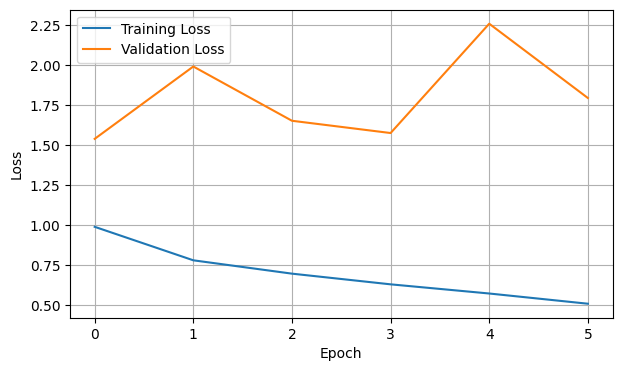

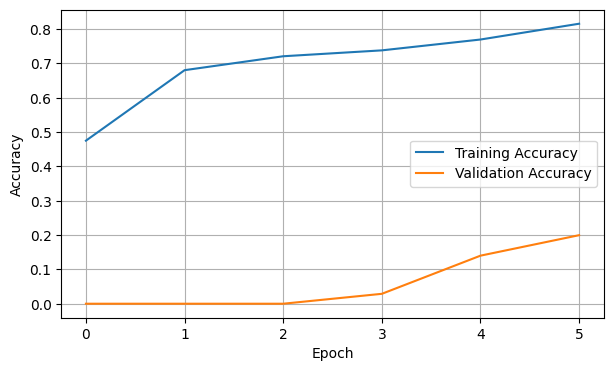

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

print("Performa Model Optimasi LSTM Tuning")

accuracy  = accuracy_score(y_test_lstm, y_pred) * 100
precision = precision_score(y_test_lstm, y_pred, average='weighted') * 100
recall    = recall_score(y_test_lstm, y_pred, average='weighted') * 100
f1        = f1_score(y_test_lstm, y_pred, average='weighted') * 100

print("\nLSTM Accuracy Score")
print(accuracy)

print("\nLSTM Precision Score")
print(precision)

print("\nLSTM Recall Score")
print(recall)

print("\nLSTM F1 Score")
print(f1)

Performa Model Optimasi LSTM Tuning


NameError: name 'y_pred' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = final_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nOptimasi LSTM")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred))
print(classification_report(
    y_test_lstm,
    y_pred,
    target_names=label_order
))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Optimasi LSTM
Akurasi: 0.6897394136807817
                 precision    recall  f1-score   support

Non-Hate Speech       0.61      0.79      0.69      1043
    Hate Speech       0.79      0.81      0.80      1069
      Provokasi       0.00      0.00      0.00       344

       accuracy                           0.69      2456
      macro avg       0.47      0.53      0.50      2456
   weighted avg       0.60      0.69      0.64      2456



In [ ]:
class_names = ['Non-Hate Speech', 'Hate Speech', 'Provokasi']

cm_opt = confusion_matrix(y_test_lstm, y_pred_opt)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
final_model.summary()

## Tuning 1.1

In [ ]:
keras_clf = KerasClassifier(
    model=build_lstm_model,
    verbose=0
)

param_dist = {
    'model__lstm_units': randint(32, 128),
    'model__dropout_rate': uniform(0.3, 0.4),
    'model__learning_rate': loguniform(1e-4, 1e-3),
    'batch_size': [32, 64],
    'epochs': [30, 50]
}

random_search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/p

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(model=<function build_lstm_model at 0x7d1062f6bc40>, verbose=0),
                   n_jobs=1,
                   param_distributions={'batch_size': [32, 64],
                                        'epochs': [30, 50],
                                        'model__dropout_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d10630d5ac0>,
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d1062f8e1b0>,
                                        'model__lstm_units': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d1062f28d40>},
                   random_state=42, scoring='f1_macro')

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': np.float64(0.6802857225639665), 'model__learning_rate': np.float64(0.0005395030966670229), 'model__lstm_units': 92}
Best CV Score: 0.8054402585192918


In [ ]:
best_params = random_search.best_params_
print("Hyperparameter Terbaik:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Hyperparameter Terbaik:
batch_size: 32
epochs: 50
model__dropout_rate: 0.6802857225639665
model__learning_rate: 0.0005395030966670229
model__lstm_units: 92


In [ ]:
print("Best CV F1-macro:", random_search.best_score_)

Best CV F1-macro: 0.8054402585192918


In [ ]:
best_params = random_search.best_params_

final_model = build_lstm_model(
    lstm_units=best_params['model__lstm_units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Model 2 LSTM + FastText + SMOTE + Tuning (tanpa early stopping)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),

    LSTM(best_params['model__lstm_units']),
    Dropout(best_params['model__dropout_rate']),

    Dense(64, activation='relu'),
    Dropout(best_params['model__dropout_rate']),

    Dense(len(np.unique(y)), activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params['model__learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,056,500 (19.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,056,500 (19.29 MB)

In [ ]:
history_final = final_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4093 - loss: 1.0512 - val_accuracy: 0.7337 - val_loss: 0.7062
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6441 - loss: 0.7963 - val_accuracy: 0.7533 - val_loss: 0.5875
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7012 - loss: 0.7146 - val_accuracy: 0.7329 - val_loss: 0.5887
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7541 - loss: 0.6313 - val_accuracy: 0.8428 - val_loss: 0.4232
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7751 - loss: 0.5693 - val_accuracy: 0.8046 - val_loss: 0.4670
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7947 - loss: 0.5363 - val_accuracy: 0.8498 - val_loss: 0.4032
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8213 - loss: 0.4877 - val_accuracy: 0.8151 - val_loss: 0.4774
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8503 - loss: 0.4451 - val_accuracy: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = final_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nTuning LSTM")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred))
print(classification_report(
    y_test_lstm,
    y_pred,
    target_names=label_order
))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Tuning LSTM
Akurasi: 0.9120521172638436
                 precision    recall  f1-score   support

Non-Hate Speech       0.94      0.92      0.93      1043
    Hate Speech       0.95      0.92      0.94      1069
      Provokasi       0.74      0.86      0.79       344

       accuracy                           0.91      2456
      macro avg       0.88      0.90      0.89      2456
   weighted avg       0.92      0.91      0.91      2456



In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

print("Performa Model Optimasi LSTM Tuning")

accuracy  = accuracy_score(y_test_lstm, y_pred) * 100
precision = precision_score(y_test_lstm, y_pred, average='weighted') * 100
recall    = recall_score(y_test_lstm, y_pred, average='weighted') * 100
f1        = f1_score(y_test_lstm, y_pred, average='weighted') * 100

print("\nLSTM Accuracy Score")
print(accuracy)

print("\nLSTM Precision Score")
print(precision)

print("\nLSTM Recall Score")
print(recall)

print("\nLSTM F1 Score")
print(f1)

Performa Model Optimasi LSTM Tuning

LSTM Accuracy Score
91.20521172638436

LSTM Precision Score
91.68935422273023

LSTM Recall Score
91.20521172638436

LSTM F1 Score
91.36651784539558


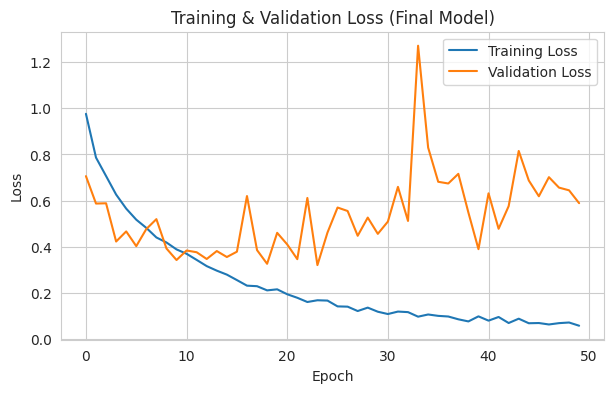

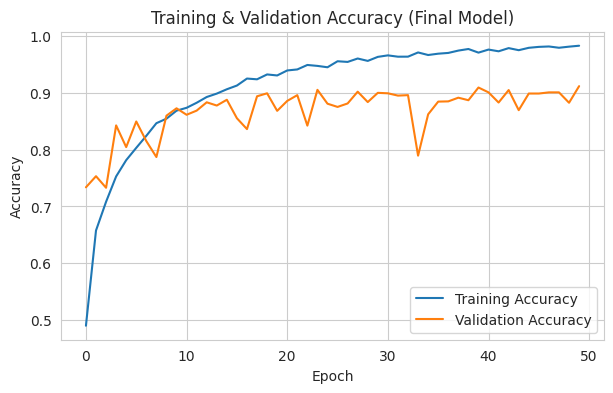

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss (Final Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training & Validation Accuracy (Final Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

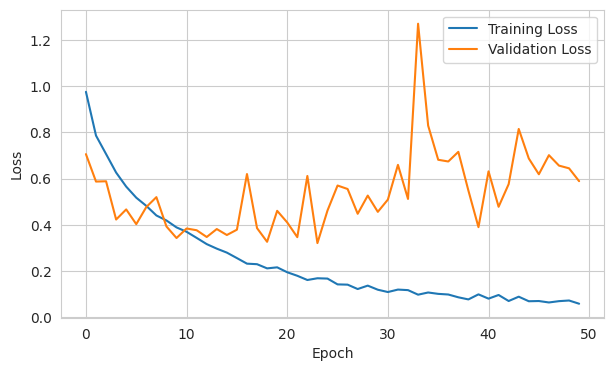

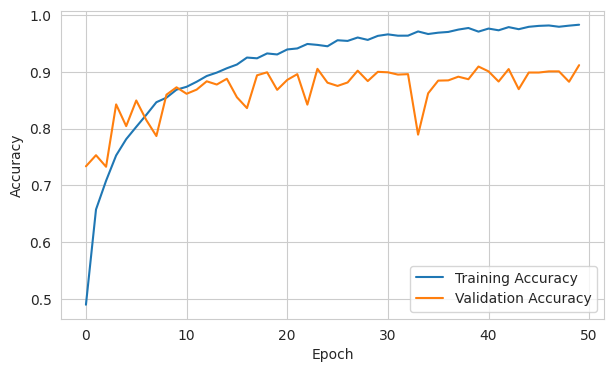

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

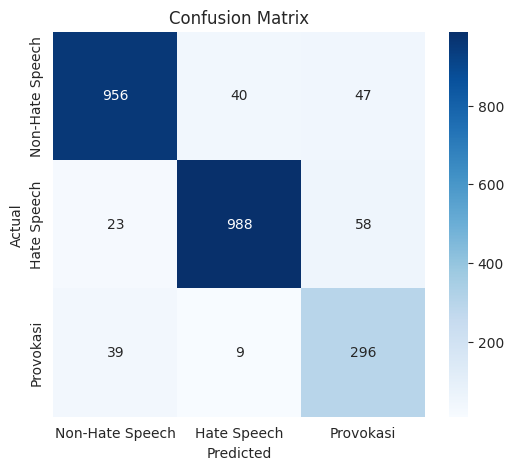

In [ ]:
cm_opt = confusion_matrix(y_test_lstm, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
final_model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 45, 300)        │     5,056,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 92)             │       144,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         5,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,508,815 (21.01 MB)

 Trainable params: 150,771 (588.95 KB)

 Non-trainable params: 5,056,500 (19.29 MB)

 Optimizer params: 301,544 (1.15 MB)

### Save Model Tuning 1 tanpa early stop

In [ ]:
final_model.save("model_lstm_fasttext_smote_tuned1_no_early_stop.keras")

## Tuning 2

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Distribusi Label Sebelum SMOTE (Data Latih)")
print(pd.Series(y_train_lstm).value_counts())

In [ ]:
from imblearn.over_sampling import SMOTE

# Flatten sequence
X_train_flat = X_train_lstm.reshape(X_train_lstm.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(
    X_train_flat, y_train_lstm
)

# Kembalikan ke bentuk sequence
X_train_smote = X_train_smote.reshape(
    X_train_smote.shape[0],
    X_train_lstm.shape[1]
)

print("\nDistribusi Label Setelah SMOTE (Data Latih)")
print(pd.Series(y_train_smote).value_counts())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE

# ================================
# Data latih SEBELUM SMOTE (LSTM)
# ================================
before_counts = pd.Series(y_train_lstm).value_counts().sort_index()
before_total = len(y_train_lstm)
before_labels = [label_order[i] for i in before_counts.index]

# ================================
# Perform SMOTE operation (moved from cell GI58EbUPNk5g)
# ================================
# Flatten sequence for SMOTE
X_train_flat = X_train_lstm.reshape(X_train_lstm.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(
    X_train_flat, y_train_lstm
)

# Reshape back to sequence form (if necessary, though not strictly used for plotting y_train_smote)
X_train_smote = X_train_smote.reshape(
    X_train_smote.shape[0],
    X_train_lstm.shape[1]
)

# ================================
# Data latih SETELAH SMOTE (LSTM)
# ================================
after_counts = pd.Series(y_train_smote).value_counts().sort_index()
after_total = len(y_train_smote)
after_labels = [label_order[i] for i in after_counts.index]

# ================================
# Plot
# ================================
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# --- Grafik Sebelum SMOTE ---
sns.barplot(
    ax=axes[0],
    x=before_labels,
    y=before_counts.values,
    palette='tab10'
)
axes[0].set_title(
    'Distribusi Kelas Data Latih Sebelum SMOTE (LSTM)',
    fontsize=12,
    pad=15
)
axes[0].set_xlabel('')
axes[0].set_ylabel('Jumlah Data')

for i, count in enumerate(before_counts.values):
    pct = f'{100 * count / before_total:.2f}%'
    axes[0].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

# --- Grafik Setelah SMOTE ---
sns.barplot(
    ax=axes[1],
    x=after_labels,
    y=after_counts.values,
    palette='tab10'
)
axes[1].set_title(
    'Distribusi Kelas Data Latih Setelah SMOTE (LSTM)',
    fontsize=12,
    pad=15
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Jumlah Data')

for i, count in enumerate(after_counts.values):
    pct = f'{100 * count / after_total:.2f}%'
    axes[1].text(
        i,
        count,
        f'{count}\n({pct})',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_lstm_model(
    lstm_units=64,
    dropout_rate=0.3,
    learning_rate=0.001
):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        ),

        LSTM(lstm_units),
        Dropout(dropout_rate),

        Dense(64, activation='relu'),
        Dropout(dropout_rate),

        Dense(len(np.unique(y)), activation='softmax')
    ])

    # Explicitly build the model to define input/output shapes
    model.build(input_shape=(None, max_len))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE

In [ ]:
keras_clf = KerasClassifier(
    model=build_lstm_model,
    verbose=0
)

param_dist = {
    'model__lstm_units': randint(32, 129), # Prefix with model__
    'model__dropout_rate': uniform(0.2, 0.3), # Prefix with model__
    'model__learning_rate': uniform(1e-4, 3e-3), # Prefix with model__
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30, 40, 50]
}

random_search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train_smote, y_train_smote)

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

In [ ]:
best_params = random_search.best_params_
print("Hyperparameter Terbaik:")
for k, v in best_params.items():
    print(f"{k}: {v}")

In [ ]:
print("Best CV F1-macro:", random_search.best_score_)

In [ ]:
best_params = random_search.best_params_

final_model = build_lstm_model(
    lstm_units=best_params['model__lstm_units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),

    LSTM(best_params['model__lstm_units']),
    Dropout(best_params['model__dropout_rate']),

    Dense(64, activation='relu'),
    Dropout(best_params['model__dropout_rate']),

    Dense(len(np.unique(y)), activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params['model__learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

In [ ]:
history_final = final_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss (Final Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training & Validation Accuracy (Final Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = final_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nTuning LSTM")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred))
print(classification_report(
    y_test_lstm,
    y_pred,
    target_names=label_order
))

In [ ]:
final_model.summary()

### Save Model Tuning 2

In [ ]:
final_model.save("model_lstm_fasttext_smote_tuned2.keras")

### Load Model Tuning 2

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("model_lstm_fasttext_smote_tuned2.keras")

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
y_pred_prob = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nTuning LSTM")
print("Akurasi:", accuracy_score(y_test_lstm, y_pred))
print(classification_report(
    y_test_lstm,
    y_pred,
    target_names=label_order
))

In [ ]:
import matplotlib.pyplot as plt # Import matplotlib.pyplot
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['Non-Hate Speech', 'Hate Speech', 'Provokasi']

cm_opt = confusion_matrix(y_test_lstm, y_pred) # Changed y_pred_opt to y_pred

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()